<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
 

Помним, что по условию соревнования, нам нужно самостоятельно собрать обучающий датасет. В этом ноутбуке мы не будем рассматривать сбор данных. Предположим, что мы уже все собрали и просто подключили свой датасет через "Add Data", чтобы приступить к самому ML.

In [1]:
# Загрузка библиотек
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
import pandas as pd # импортируем необходимые библиотеки
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import ExtraTreeRegressor
from sklearn.cluster import KMeans
from sklearn.base import clone
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm
from collections import Counter
%matplotlib inline

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Setup

In [4]:
VERSION    = 110
DIR_TRAIN  = '../input/autorubmw/' # подключил к ноутбуку свой внешний датасет
DIR_AVITO  = '../input/bmwavito/' # подключил к ноутбуку свой внешний датасет
DIR_TEST   = '../input/sf-dst-car-price/'
VAL_SIZE   = 0.2   # 20%
N_FOLDS    = 5

# CATBOOST
ITERATIONS = 6000
LR         = 0.1

RANDOM_SEED = 42

# Data

In [5]:
!ls ../input/

autorubmw  bmwavito  sf-autoru-solve-v4  sf-dst-car-price


# EDA для тестовой выборки
Цель данного упражнения:
* Ознакомиться с данными, которые у нас есть
* Понять, какую информацию мы сможем из них взять
* Понять, какие данные влияют на целевую переменную, а какие нет
* Понять, какие данные необходимо собирать из внешних источников
* Сформировать желаемый вид датасета, к которому будем стремиться преобразовать собранные данные

## Первичный осмотр данных
Посмотрим на тестовые данные.

In [6]:
df = pd.read_csv(DIR_TEST+'test.csv')

In [7]:
display(df.head())
df.info()

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,id
0,седан,BMW,чёрный,дизель,2016.0,520d 2.0d AT (190 л.с.),4.0,2017.0,SEDAN AUTOMATIC 2.0,автоматическая,...,158836.0,"['[{""name"":""Безопасность"",""values"":[""Антипробу...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,0
1,седан,BMW,белый,дизель,2018.0,318d 2.0d AT (150 л.с.),4.0,2019.0,SEDAN AUTOMATIC 2.0,автоматическая,...,10.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,1
2,седан,BMW,синий,бензин,2009.0,550i xDrive 4.4 AT (407 л.с.) 4WD,4.0,2012.0,SEDAN AUTOMATIC 4.4,автоматическая,...,120000.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,2 владельца,Оригинал,Растаможен,7 лет и 2 месяца,2
3,внедорожник 5 дв.,BMW,белый,дизель,2014.0,30d 3.0d AT (249 л.с.) 4WD,5.0,2015.0,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,...,111466.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,2 владельца,Оригинал,Растаможен,NaN,3
4,внедорожник 5 дв.,BMW,синий,дизель,2014.0,M50d 3.0d AT (381 л.с.) 4WD,5.0,2019.0,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,...,11891.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3837 entries, 0 to 3836
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              3837 non-null   object 
 1   brand                 3837 non-null   object 
 2   color                 3837 non-null   object 
 3   fuelType              3837 non-null   object 
 4   modelDate             3837 non-null   float64
 5   name                  3837 non-null   object 
 6   numberOfDoors         3837 non-null   float64
 7   productionDate        3837 non-null   float64
 8   vehicleConfiguration  3837 non-null   object 
 9   vehicleTransmission   3837 non-null   object 
 10  engineDisplacement    3837 non-null   object 
 11  enginePower           3837 non-null   object 
 12  description           3837 non-null   object 
 13  mileage               3837 non-null   float64
 14  Комплектация          3837 non-null   object 
 15  Привод               

Всего в датасете 6 числовых и 18 строковых столбцов. Пропуски есть только в столбце "Владение".

Для удобства переименуем столбцы

In [8]:
df.columns = ([
    'bodyType',
    'brand',
    'color',
    'fuelType',
    'modelDate',
    'name',
    'numberOfDoors',
    'productionDate',
    'vehicleConfiguration',
    'vehicleTransmission',
    'engineDisplacement',
    'enginePower',
    'description',
    'mileage',
    'equipment',
    'drive',
    'wheel',
    'state',
    'owners',
    'technicalPassport',
    'customs',
    'ownership',
    'id',
])

# Первичный осмотр данных в столбцах

**Для начала посмотрим на признаки и разделим их на типы.**
1. Числовые - 6: modelDate, numberOfDoors, productionDate, milage, id
1. Категориальные - 17 шт.: bodyType, brand, color, fuelType, name, vehicleConfiguration, vehicleTransmission, engineDisplacement, enginePower, equipment, drive, wheel, state,    owners,technicalPassport, сustoms, ownership.
1. Текстовое поле с описанием "description"

Возможно, первоначальное разбиение неверное, но мы скоро это проверим.
Разбить категориальные признаки на бинарные и оценочные мы сможем после того, как внимательно посмотрим на каждый признак.

Dummy-переменные пока что делать не будем т.к. для CatBoost это не нужно.

Начнем с числовых признаков

## Числовые признаки

## modelDate
Год выпуска модели

Напишем функцию, которая выдаст нам необходимую информацию для первичного анализа признака.

In [9]:
def col_info(ys):
    print('Количество пропусков: {},'.format(ys.isnull().sum()))
    print('{},'.format(ys.describe()))
    print('Распределение:\n{},'.format(ys.value_counts()))
    ys.hist()

Применим функцию для анализа признака:

Количество пропусков: 0,
count    3837.000000
mean     2009.948137
std         5.451623
min      1975.000000
25%      2007.000000
50%      2011.000000
75%      2014.000000
max      2019.000000
Name: modelDate, dtype: float64,
Распределение:
2013.0    380
2011.0    373
2009.0    359
2010.0    308
2007.0    296
2015.0    285
2014.0    267
2012.0    215
2006.0    210
2008.0    191
2016.0    161
2018.0    125
2017.0    122
2005.0    116
2003.0     89
2002.0     54
2001.0     45
1995.0     44
1999.0     35
2000.0     33
1998.0     33
2019.0     26
1987.0     18
1990.0     13
2004.0     12
1982.0     11
1994.0      8
1981.0      3
1986.0      3
1975.0      1
1977.0      1
Name: modelDate, dtype: int64,


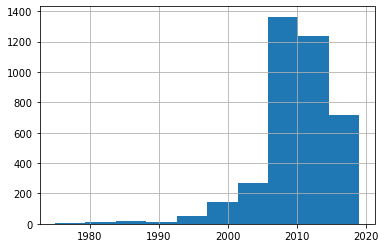

In [10]:
col_info(df.modelDate)

Видим, что в датасете представлены автомобили с 1975 по 2019 год выпуска модели. Пропусков нет. Возможно, стоит подумать о преобразовании признака в "возраст модели".

Предположим, что данные собирались в начале 2020 года.

In [11]:
df['modelDate']=2020-df['modelDate']

Количество пропусков: 0,
count    3837.000000
mean       10.051863
std         5.451623
min         1.000000
25%         6.000000
50%         9.000000
75%        13.000000
max        45.000000
Name: modelDate, dtype: float64,
Распределение:
7.0     380
9.0     373
11.0    359
10.0    308
13.0    296
5.0     285
6.0     267
8.0     215
14.0    210
12.0    191
4.0     161
2.0     125
3.0     122
15.0    116
17.0     89
18.0     54
19.0     45
25.0     44
21.0     35
20.0     33
22.0     33
1.0      26
33.0     18
30.0     13
16.0     12
38.0     11
26.0      8
34.0      3
39.0      3
45.0      1
43.0      1
Name: modelDate, dtype: int64,


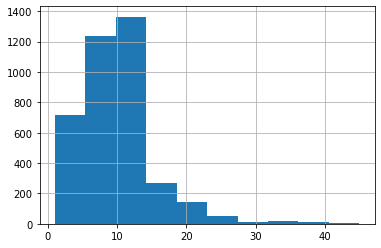

In [12]:
col_info(df.modelDate)

Переименуем столбец в 'modelAge'

In [13]:
df.rename(columns = {'modelDate':'modelAge'}, inplace = True) 

## numberOfDoors
Количество дверей

Количество пропусков: 0,
count    3837.000000
mean        4.375033
std         0.796782
min         2.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: numberOfDoors, dtype: float64,
Распределение:
5.0    1963
4.0    1594
2.0     244
3.0      36
Name: numberOfDoors, dtype: int64,


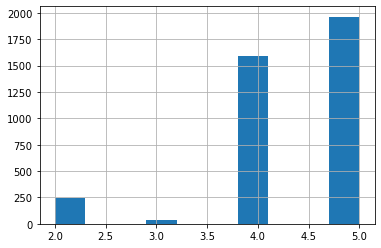

In [14]:
col_info(df.numberOfDoors)

В данном признаке 4 варианта количества дверей, пропусков или явных ошибок нет. 
Количество дверей скорее определяет категорию автомобиля, следовательно данная переменная скорее категориальная.

Сделаем значение строковым.

In [15]:
df['numberOfDoors'] = df['numberOfDoors'].apply(lambda s: str(int(s)))

## productionDate
Дата производства авто

Количество пропусков: 0,
count    3837.000000
mean     2011.934584
std         5.186576
min      1981.000000
25%      2010.000000
50%      2013.000000
75%      2016.000000
max      2019.000000
Name: productionDate, dtype: float64,
Распределение:
2013.0    432
2012.0    386
2011.0    345
2014.0    312
2018.0    267
2019.0    262
2016.0    254
2015.0    229
2008.0    228
2010.0    205
2017.0    196
2007.0    149
2009.0    142
2005.0     63
2004.0     60
2006.0     52
2003.0     48
2002.0     41
2001.0     36
1998.0     22
2000.0     22
1999.0     20
1997.0     14
1996.0      9
1992.0      8
1995.0      6
1989.0      6
1993.0      6
1984.0      3
1991.0      3
1994.0      2
1982.0      2
1988.0      2
1990.0      2
1986.0      1
1987.0      1
1981.0      1
Name: productionDate, dtype: int64,


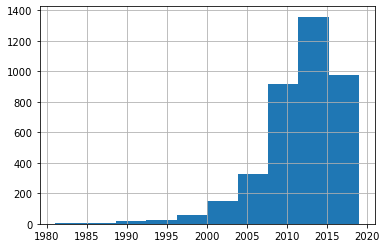

In [16]:
col_info(df.productionDate)

Преобразуем данный признак в возраст автомобиля. И переименуем столбец в 'age'. Выбросы пока что трогать не будем.

In [17]:
df['productionDate']=2020-df['productionDate']
df.rename(columns = {'productionDate':'age'}, inplace = True) 

У получившегося признака 'age' будет высокая корреляция с возрастом модели. Возраст модели в дальнейшем, скорее всего, удалим т.к. чаще смотрят на возраст машины. Точный ответ нам даст корреляционный анализ.

## mileage
Пробег

Количество пропусков: 0,
count       3837.000000
mean      118536.361480
std        85125.949826
min            1.000000
25%        58562.000000
50%       108000.000000
75%       160789.000000
max      1000000.000000
Name: mileage, dtype: float64,
Распределение:
140000.0    38
120000.0    32
200000.0    31
160000.0    30
130000.0    29
            ..
82213.0      1
102996.0     1
88383.0      1
83512.0      1
88400.0      1
Name: mileage, Length: 1942, dtype: int64,


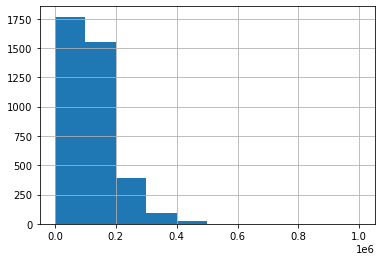

In [18]:
col_info(df.mileage)

Данные выглядят вполне нормально. Видим, что все машины с пробегом, новых нет.

## id

На всякий случай посмотрим, нет ли тут подвоха

Количество пропусков: 0,
count    3837.00000
mean     1918.00000
std      1107.79082
min         0.00000
25%       959.00000
50%      1918.00000
75%      2877.00000
max      3836.00000
Name: id, dtype: float64,
Распределение:
2047    1
2676    1
2700    1
649     1
2696    1
       ..
1270    1
3315    1
1266    1
3311    1
0       1
Name: id, Length: 3837, dtype: int64,


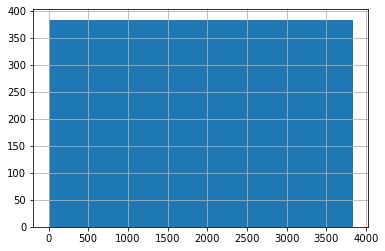

In [19]:
col_info(df.id)

Выглядит нормально. Данный признак нам не понадобится, удалим его.

In [20]:
df=df.drop('id', axis=1)

# Категориальные признаки

## bodyType
Тип кузова

Количество пропусков: 0,
count                  3837
unique                   11
top       внедорожник 5 дв.
freq                   1626
Name: bodyType, dtype: object,
Распределение:
внедорожник 5 дв.    1626
седан                1594
купе                  214
хэтчбек 5 дв.         163
лифтбек               125
универсал 5 дв.        46
хэтчбек 3 дв.          36
кабриолет              19
родстер                10
компактвэн              3
седан 2 дв.             1
Name: bodyType, dtype: int64,


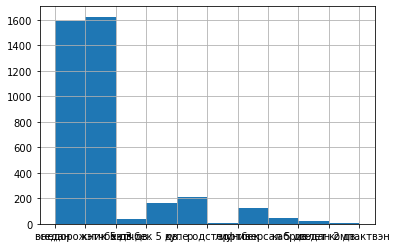

In [21]:
col_info(df.bodyType)

Для количества дверей у нас есть отдельный признак. Переименуем значения в данной колонке.

In [22]:
df.bodyType = df.bodyType.str.split().apply(lambda s: s[0])
dic_bodyType = {
    'седан': 'sedan',
    'внедорожник': 'SUV',
    'хэтчбек': 'hatchback',
    'купе': 'coupe',
    'родстер': 'roadster',
    'лифтбек': 'liftback',
    'универсал': 'wagon',
    'кабриолет': 'cabriolet',
    'компактвэн': 'van'
}
df['bodyType'] = df['bodyType'].map(dic_bodyType)

Количество пропусков: 0,
count     3837
unique       9
top        SUV
freq      1626
Name: bodyType, dtype: object,
Распределение:
SUV          1626
sedan        1595
coupe         214
hatchback     199
liftback      125
wagon          46
cabriolet      19
roadster       10
van             3
Name: bodyType, dtype: int64,


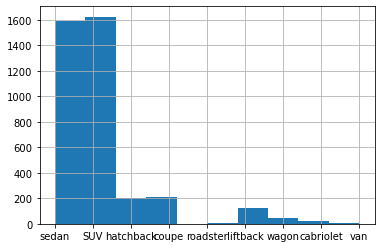

In [23]:
col_info(df.bodyType)

В итоге у нас осталось 9 типов кузова. Большинство автомобилей - седаны и кроссоверы.

## brand

Количество пропусков: 0,
count     3837
unique       1
top        BMW
freq      3837
Name: brand, dtype: object,
Распределение:
BMW    3837
Name: brand, dtype: int64,


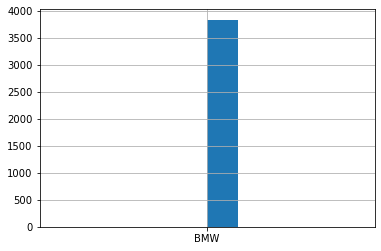

In [24]:
col_info(df.brand)

У нас только BMW, следовательно данный столбец нам не понадобится. Удалим его.

In [25]:
df=df.drop('brand', axis=1)

## color
Цвет

Количество пропусков: 0,
count       3837
unique        15
top       чёрный
freq        1395
Name: color, dtype: object,
Распределение:
чёрный         1395
белый           767
синий           510
серый           453
коричневый      216
серебристый     191
красный         115
бежевый          46
голубой          35
зелёный          33
оранжевый        27
золотистый       23
пурпурный        20
фиолетовый        5
жёлтый            1
Name: color, dtype: int64,


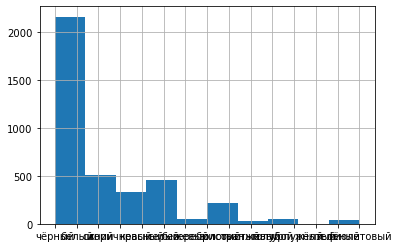

In [26]:
col_info(df.color)

Переименуем цвета

In [27]:
dic_color = {
    'чёрный': 'black',
    'белый': 'white',
    'синий': 'dark_blue',
    'коричневый': 'brown',
    'красный': 'red',
    'серый': 'grey',
    'бежевый': 'biege',
    'серебристый': 'silver',
    'золотистый': 'golden',
    'оранжевый': 'orange',
    'голубой': 'blue',
    'пурпурный': 'purple',
    'жёлтый': 'yellow',
    'зелёный': 'green',
    'фиолетовый': 'violet'
}
df['color'] = df['color'].map(dic_color)

## fuelType
Тип топлива

Количество пропусков: 0,
count       3837
unique         4
top       бензин
freq        2471
Name: fuelType, dtype: object,
Распределение:
бензин     2471
дизель     1358
гибрид        7
электро       1
Name: fuelType, dtype: int64,


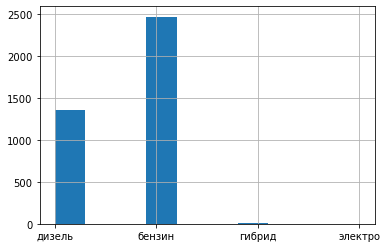

In [28]:
col_info(df.fuelType)

Как видим, в тестовой выбоке 4 вида топлива. Переименуем значения.

In [29]:
dic_fuelType = {
    'дизель': 'diesel',
    'бензин': 'petrol',
    'гибрид': 'hybrid',
    'электро': 'electro'
}
df['fuelType'] = df['fuelType'].map(dic_fuelType)

## name
название модели

Количество пропусков: 0,
count                          3837
unique                          384
top       35i 3.0 AT (306 л.с.) 4WD
freq                            193
Name: name, dtype: object,
Распределение:
35i 3.0 AT (306 л.с.) 4WD            193
30d 3.0d AT (249 л.с.) 4WD           148
520i 2.0 AT (184 л.с.)               103
320i xDrive 2.0 AT (184 л.с.) 4WD     92
320i 2.0 AT (184 л.с.)                91
                                    ... 
528i 3.0 AT (243 л.с.)                 1
428i 2.0 AT (245 л.с.)                 1
430i 2.0 AT (249 л.с.)                 1
520d 2.0d MT (177 л.с.)                1
3.0d 2.9d AT (184 л.с.) 4WD            1
Name: name, Length: 384, dtype: int64,


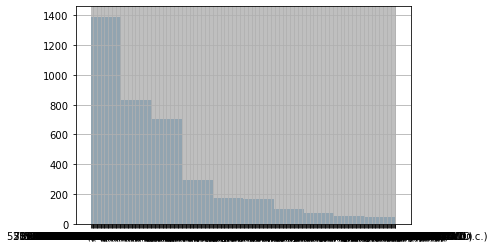

In [30]:
col_info(df.name)

В данном столбце мы видим название модели, объем двигателя, тип трансмиссии, мощность двигателя и признак полноприводности.
Для всего, кроме названия модели у нас уже есть отдельные столбцы. Отсечем лишнее.

In [31]:
df['name'] = df['name'].str.split().apply(lambda s: s[0])

Количество пропусков: 0,
count     3837
unique     135
top        30d
freq       284
Name: name, dtype: object,
Распределение:
30d      284
320i     263
20d      226
35i      203
520i     142
        ... 
735Li      1
545i       1
330xd      1
528Li      1
518        1
Name: name, Length: 135, dtype: int64,


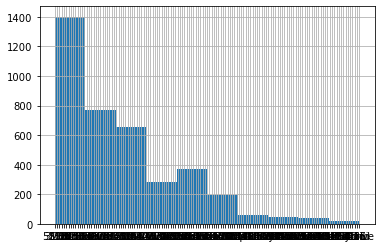

In [32]:
col_info(df.name)

Количество уникальных значений сократилось до 135. Возможно, стоит предварительно сократить количество уникальных значений, сделав группировку по моделям.

## vehicleConfiguration

Количество пропусков: 0,
count                              3837
unique                               99
top       ALLROAD_5_DOORS AUTOMATIC 3.0
freq                                850
Name: vehicleConfiguration, dtype: object,
Распределение:
ALLROAD_5_DOORS AUTOMATIC 3.0       850
SEDAN AUTOMATIC 2.0                 764
ALLROAD_5_DOORS AUTOMATIC 2.0       534
SEDAN AUTOMATIC 3.0                 359
SEDAN AUTOMATIC 2.5                 155
                                   ... 
ROADSTER AUTOMATIC 2.2                1
COMPACTVAN AUTOMATIC 1.5              1
WAGON_5_DOORS MECHANICAL 2.8          1
HATCHBACK_5_DOORS MECHANICAL 3.0      1
ROADSTER AUTOMATIC 2.5                1
Name: vehicleConfiguration, Length: 99, dtype: int64,


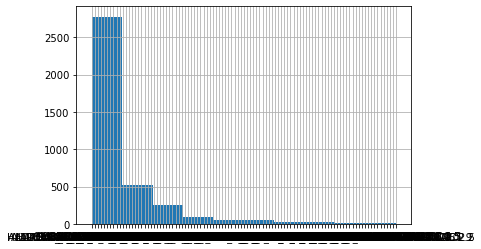

In [33]:
col_info(df.vehicleConfiguration)

В данном столбце указаны тип кузова, количество дверей, тип трансмиссии и объем двигателя. Все эти данные у нас уже есть в других столбцах, так что можем смело удалять.

In [34]:
df=df.drop('vehicleConfiguration', axis=1)

## vehicleTransmission
Тип коробки передач

Количество пропусков: 0,
count               3837
unique                 3
top       автоматическая
freq                3677
Name: vehicleTransmission, dtype: object,
Распределение:
автоматическая      3677
механическая         111
роботизированная      49
Name: vehicleTransmission, dtype: int64,


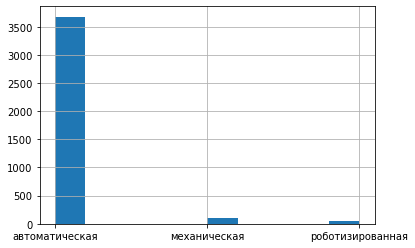

In [35]:
col_info(df.vehicleTransmission)

3 уникальных значения. Переименуем для удобства.

In [36]:
dic_vehicleTransmission = {
    'автоматическая': 'AT',
    'механическая': 'MT',
    'роботизированная': 'AM'
}
df['vehicleTransmission'] = df['vehicleTransmission'].map(dic_vehicleTransmission)

## engineDisplacement
Объем двигателя

Количество пропусков: 0,
count        3837
unique         22
top       2.0 LTR
freq         1538
Name: engineDisplacement, dtype: object,
Распределение:
2.0 LTR          1538
3.0 LTR          1353
4.4 LTR           305
2.5 LTR           239
1.6 LTR           173
1.5 LTR            66
4.8 LTR            64
2.2 LTR            20
2.8 LTR            14
4.0 LTR            13
1.8 LTR            10
1.9 LTR             7
5.4 LTR             6
6.0 LTR             5
4.6 LTR             4
6.6 LTR             4
2.9 LTR             4
3.5 LTR             4
3.6 LTR             3
5.0 LTR             3
3.4 LTR             1
undefined LTR       1
Name: engineDisplacement, dtype: int64,


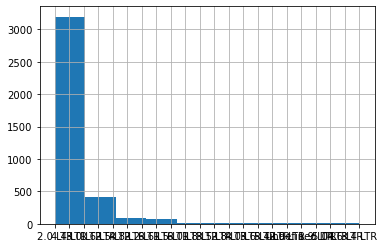

In [37]:
col_info(df.engineDisplacement)

Удалим "LTR" из значений признака.

In [38]:
df['engineDisplacement'] = df['engineDisplacement'].str.split().apply(lambda s: s[0])

Количество пропусков: 0,
count     3837
unique      22
top        2.0
freq      1538
Name: engineDisplacement, dtype: object,
Распределение:
2.0          1538
3.0          1353
4.4           305
2.5           239
1.6           173
1.5            66
4.8            64
2.2            20
2.8            14
4.0            13
1.8            10
1.9             7
5.4             6
6.0             5
2.9             4
6.6             4
3.5             4
4.6             4
3.6             3
5.0             3
undefined       1
3.4             1
Name: engineDisplacement, dtype: int64,


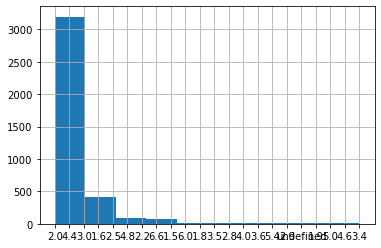

In [39]:
col_info(df.engineDisplacement)

Видим, что данный признак можно сделать числовым. Заменим значение 'undefined' на самое частое "2.0" и преобразуем все значения в тип float.

In [40]:
df.loc[df.engineDisplacement=='undefined', 'engineDisplacement'] = '2.0'
df['engineDisplacement'] = df['engineDisplacement'].apply(lambda s: float(s))

## enginePower
Мощность двигателя

Количество пропусков: 0,
count        3837
unique         75
top       184 N12
freq          636
Name: enginePower, dtype: object,
Распределение:
184 N12    636
249 N12    300
245 N12    293
306 N12    281
190 N12    260
          ... 
460 N12      1
252 N12      1
609 N12      1
243 N12      1
90 N12       1
Name: enginePower, Length: 75, dtype: int64,


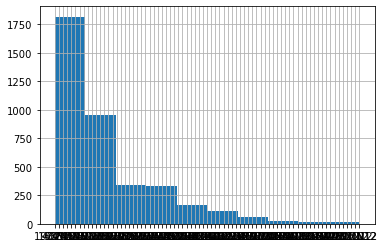

In [41]:
col_info(df.enginePower)

Удалим "N12"

In [42]:
df['enginePower'] = df['enginePower'].str.split().apply(lambda s: s[0])

Видим, что данный признак можно сделать числовым. Преобразуем все значения в тип float.

In [43]:
df['enginePower'] = df['enginePower'].apply(lambda s: float(s))

## description
Описание

Возможно, есть смысл анализировать описание, но времени на это скорее всего не хватит. Удалим данные признак.

In [44]:
df=df.drop('description', axis=1)

## equipment
Комплектация

Посмотрим для примера на комплектацию первого автомобиля.

In [45]:
df.equipment[0]

'[\'[{"name":"Безопасность","values":["Антипробуксовочная система (ASR)","Система стабилизации (ESP)","Подушка безопасности водителя","Крепление детского кресла (задний ряд) ISOFIX","Подушки безопасности оконные (шторки)","Подушка безопасности пассажира","Подушки безопасности боковые задние","Подушки безопасности боковые","Датчик давления в шинах","Антиблокировочная система (ABS)","Блокировка замков задних дверей","Подушка безопасности для защиты коленей водителя"]},{"name":"Комфорт","values":["Система «старт-стоп»","Электростеклоподъёмники передние","Мультифункциональное рулевое колесо","Прикуриватель и пепельница","Бортовой компьютер","Усилитель руля","Электропривод зеркал","Электростеклоподъёмники задние","Парктроник передний","Регулировка руля по вылету","Климат-контроль 2-зонный","Электроскладывание зеркал","Парктроник задний"]},{"name":"Мультимедиа","values":["AUX","USB","Аудиосистема","Bluetooth"]},{"name":"Обзор","values":["Датчик света","Автоматический корректор фар","Омывател

Видим словарь из категорий (безопасность, комфорт, салон и т.д.), в каждой категории список фич. В идеале неплохо было бы для каждой фичи сделать dummy-переменную. Но для начала посмотрим, что нам удастся загрузить из внешних источников. Если данных будет мало, то проще удалить этот признак.

## drive
Привод

Количество пропусков: 0,
count       3837
unique         3
top       полный
freq        2444
Name: drive, dtype: object,
Распределение:
полный      2444
задний      1378
передний      15
Name: drive, dtype: int64,


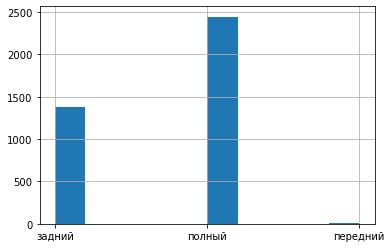

In [46]:
col_info(df.drive)

Переименуем значения

In [47]:
dic_drive = {
    'задний': 'rwd',
    'полный': '4wd',
    'передний': 'fwd'
}
df['drive'] = df['drive'].map(dic_drive)

## wheel
Руль (Левый/Правый)

Количество пропусков: 0,
count      3837
unique        1
top       Левый
freq       3837
Name: wheel, dtype: object,
Распределение:
Левый    3837
Name: wheel, dtype: int64,


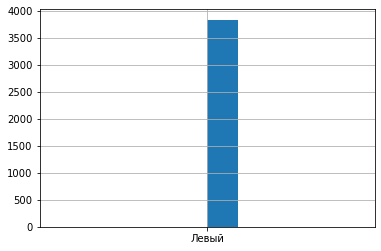

In [48]:
col_info(df.wheel)

У нас только ловорульные автомобили. Следовательно, из внешних источников будем выгружать только леворульные автомобили.
Удалим этот признак.

In [49]:
df=df.drop('wheel', axis=1)

## state
Состояние автомобиля

Количество пропусков: 0,
count                   3837
unique                     1
top       Не требует ремонта
freq                    3837
Name: state, dtype: object,
Распределение:
Не требует ремонта    3837
Name: state, dtype: int64,


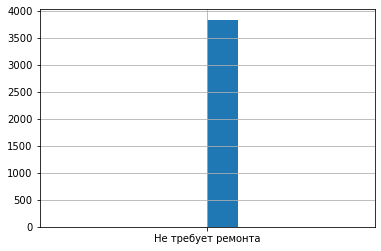

In [50]:
col_info(df.state)

В нашей тестовой выборке только автомобили, не требующие ремонта. Будем использовать эту информацию при загрузке данных из внешних источников.
Удалим этот признак.

In [51]:
df = df.drop('state', axis=1)

## owners

Количество пропусков: 0,
count            3837
unique              3
top       3 или более
freq             1516
Name: owners, dtype: object,
Распределение:
3 или более    1516
1 владелец     1309
2 владельца    1012
Name: owners, dtype: int64,


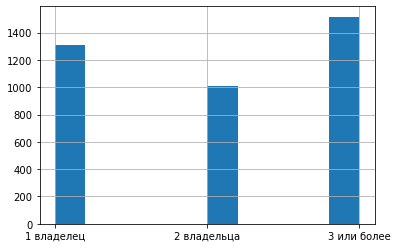

In [52]:
col_info(df.owners)

Заменим на числовые значения

In [53]:
df.owners.unique()

array(['1\xa0владелец', '2\xa0владельца', '3 или более'], dtype=object)

In [54]:
dic_owners = {
    '1\xa0владелец': 1,
    '2\xa0владельца': 2,
    '3 или более': 3
}
df['owners'] = df['owners'].map(dic_owners)

## technicalPassport
ПТС

Количество пропусков: 0,
count         3837
unique           2
top       Оригинал
freq          3463
Name: technicalPassport, dtype: object,
Распределение:
Оригинал    3463
Дубликат     374
Name: technicalPassport, dtype: int64,


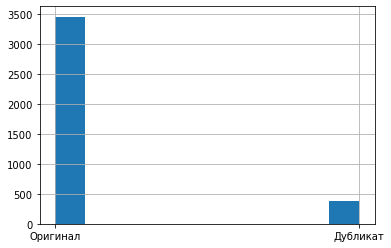

In [55]:
col_info(df.technicalPassport)

У нас всего 2 варианта. Преобразуем переменную в бинарную.

In [56]:
dic_technicalPassport = {
    'Оригинал': 1,
    'Дубликат': 0
}
df['technicalPassport'] = df['technicalPassport'].map(dic_technicalPassport)

## customs

Количество пропусков: 0,
count           3837
unique             1
top       Растаможен
freq            3837
Name: customs, dtype: object,
Распределение:
Растаможен    3837
Name: customs, dtype: int64,


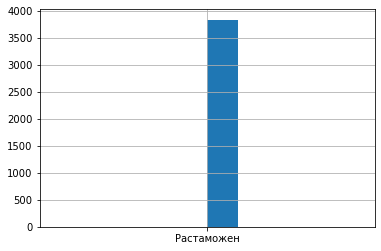

In [57]:
col_info(df.customs)

В нашей тестовой выборке только растоможенные автомобили. Будем использовать эту информацию при загрузке данных из внешних источников. Удалим этот признак.

In [58]:
df = df.drop('customs', axis=1)

## ownership

Количество пропусков: 2084,
count                1753
unique                157
top       1 год и 1 месяц
freq                   40
Name: ownership, dtype: object,
Распределение:
1 год и 1 месяц        40
1 год и 4 месяца       39
1 год и 3 месяца       37
1 год и 2 месяца       36
1 год и 8 месяцев      33
                       ..
12 лет и 11 месяцев     1
13 лет и 1 месяц        1
11 лет и 1 месяц        1
15 лет и 9 месяцев      1
27 лет и 3 месяца       1
Name: ownership, Length: 157, dtype: int64,


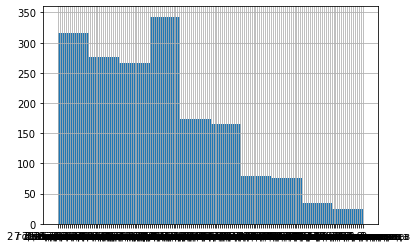

In [59]:
col_info(df.ownership)

В данном столбце слишком много пропусков. Кроме того, срок владения не является критичной информацией, когда есть возраст автомобиля (но это не точно). Удалим данный столбец.

In [60]:
df = df.drop('ownership', axis = 1)

# Выводы по результатам EDA для тестовой выборки

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3837 entries, 0 to 3836
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             3837 non-null   object 
 1   color                3837 non-null   object 
 2   fuelType             3837 non-null   object 
 3   modelAge             3837 non-null   float64
 4   name                 3837 non-null   object 
 5   numberOfDoors        3837 non-null   object 
 6   age                  3837 non-null   float64
 7   vehicleTransmission  3837 non-null   object 
 8   engineDisplacement   3837 non-null   float64
 9   enginePower          3837 non-null   float64
 10  mileage              3837 non-null   float64
 11  equipment            3837 non-null   object 
 12  drive                3837 non-null   object 
 13  owners               3837 non-null   int64  
 14  technicalPassport    3837 non-null   int64  
dtypes: float64(5), int64(2), object(8)
mem

У нас осталось 15 признаков:

    Числовые - 7: modelAge, age, engineDisplacement, enginePower, milage
    Категориальные оценочные - 17 шт.: bodyType, color, fuelType, name, numberOfDoors, vehicleTransmission, equipment, drive, owners
    Категориальные бинарные - 1 шт.: technicalPassport

Чего не хватает:
* В датасете нет однозначной информации о модели машины. Например, 30d может относиться к моделям X3, X3, X5, X6 и, возможно, ещё к каким-то.
Видимо нам нужно будет научиться понимать модель по имеющимся данным (год выпуска, объем двигателя и т.д.).

При сборе данных из внешних источников мы будем использовать следующие фильтры:

* Марка - БМВ до 2019 года производства
* Автомобили с пробегом
* Левый руль
* Состояние - не требует ремонта
* Растоможен

In [62]:
df.head()

,bodyType,color,fuelType,modelAge,name,numberOfDoors,age,vehicleTransmission,engineDisplacement,enginePower,mileage,equipment,drive,owners,technicalPassport
0,sedan,black,diesel,4.0,520d,4,3.0,AT,2.0,190.0,158836.0,"['[{""name"":""Безопасность"",""values"":[""Антипробу...",rwd,1,1
1,sedan,white,diesel,2.0,318d,4,1.0,AT,2.0,150.0,10.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",rwd,1,1
2,sedan,dark_blue,petrol,11.0,550i,4,8.0,AT,4.4,407.0,120000.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",4wd,2,1
3,SUV,white,diesel,6.0,30d,5,5.0,AT,3.0,249.0,111466.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",4wd,2,1
4,SUV,dark_blue,diesel,6.0,M50d,5,1.0,AT,3.0,381.0,11891.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",4wd,1,1


## ---------------------------------------------

# Загрузка данных из внешних источников

## Auto.ru

Для загрузки данных об автомобилях с авто.ру был разработан парсер:
https://github.com/feD0s/skillfactory_rds/blob/master/module_3_auto/autoru_parser.ipynb
На выходе мы получили файлы в формате json, содержащие интересующую нас выгрузку.

Далее был произведен анализ json-файлов и преобразование признаков:
https://github.com/feD0s/skillfactory_rds/blob/master/module_3_auto/df_autoru.ipynb
На выходе мы получили данные с авто.ру - autoru.csv: https://github.com/feD0s/skillfactory_rds/blob/master/module_3_auto/autoru.csv, который подгрузили на kaggle.


## Avito.ru

Для загрузки данных об автомобилях с авито был разработан парсер:
https://github.com/tatianazhemantseva/Car-price-prediction/blob/master/Parsing_BMW_avito.ipynb
На выходе мы получили файл в формате csv, содержащий интересующую нас выгрузку.

Далее был произведен анализ csv-файла и преобразование признаков:
https://github.com/feD0s/skillfactory_rds/blob/master/module_3_auto/df_avito.ipynb
На выходе мы получили данные с авито - avito.csv: https://github.com/feD0s/skillfactory_rds/blob/master/module_3_auto/avito.csv.


In [63]:
train = pd.read_csv(DIR_TRAIN+'autoru.csv') # мой подготовленный датасет для обучения модели
avito = pd.read_csv(DIR_AVITO+'avito.csv') # мой подготовленный датасет для обучения модели
train = train.drop('Unnamed: 0',axis=1)     # удаляем лишний столбец с id
train.rename(columns = {'':'price'}, inplace = True)  # Переименуем целевую переменную
test = df
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

Приведем столбцы к одному порядку

In [64]:
sorted(avito.columns.unique())

['age',
 'bodyType',
 'color',
 'drive',
 'engineDisplacement',
 'enginePower',
 'equipment',
 'fuelType',
 'mileage',
 'model',
 'modelAge',
 'name',
 'numberOfDoors',
 'owners',
 'price',
 'state',
 'technicalPassport',
 'vehicleTransmission']

In [65]:
test = df[[
    'age',
    'bodyType',
    'color',
    'drive',
    'engineDisplacement',
    'enginePower',
    'equipment',
    'fuelType',
    'mileage',
    'modelAge',
    'name',
    'numberOfDoors',
    'owners',
    'technicalPassport',
    'vehicleTransmission'
]]

In [66]:
train = train[[
    'age',
    'bodyType',
    'color',
    'drive',
    'engineDisplacement',
    'enginePower',
    'equipment',
    'fuelType',
    'mileage',
    'modelAge',
    'name',
    'numberOfDoors',
    'owners',
    'technicalPassport',
    'vehicleTransmission',
    'acceleration',
    'autoClass',
    'fuelRate',
    'insurancePrice',
    'priceDiff',   
    'rating',
    'tags',
    'taxPrice',
    'model',
    'price',
]]

In [67]:
avito = avito[[
    'age',
    'bodyType',
    'color',
    'drive',
    'engineDisplacement',
    'enginePower',
    'equipment',
    'fuelType',
    'mileage',
    'modelAge',
    'name',
    'numberOfDoors',
    'owners',
    'technicalPassport',
    'vehicleTransmission',
    'model',
    'price',
    'state',    
]]
avito = avito.drop('state',axis=1)

# EDA для тренировочной и тестовой выборки

На данном этапе ещё раз пройдемся по каждому параметру для приведения в финальный вид перед обучением модели.

## mileagePerYear

Пока мы не преобразовали признаки age и mileage, создадим ещё один признак - mileagePerYear, который покажет, насколько интенсивно использовали автомобиль.

In [68]:
train['age']=train['age'].astype('float')
test['age']=test['age'].astype('float')
avito['age']=avito['age'].astype('float')
train['mileage']=train['mileage'].astype('float')
test['mileage']=test['mileage'].astype('float')
avito['mileage']=avito['mileage'].astype('float')

In [69]:
train['mileagePerYear'] = train['mileage'] / train['age']
avito['mileagePerYear'] = avito['mileage'] / avito['age']
test['mileagePerYear'] = test['mileage'] / test['age']

Количество пропусков: 0,
count     3837.000000
mean     14355.123981
std       7134.752022
min          1.000000
25%      10033.333333
50%      14125.000000
75%      18062.500000
max      70086.333333
Name: mileagePerYear, dtype: float64,
Распределение:
15000.000000    40
14000.000000    25
20000.000000    25
10000.000000    25
17500.000000    22
                ..
23206.285714     1
12620.000000     1
11860.000000     1
12157.923077     1
1824.000000      1
Name: mileagePerYear, Length: 2434, dtype: int64,


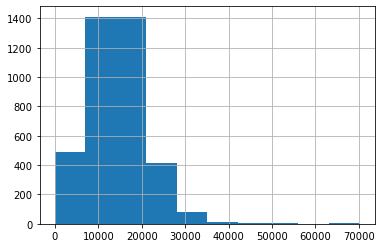

In [70]:
col_info(test.mileagePerYear)

Напишем функцию отсечения выбросов по формуле интерквартильного расстояния и отрисовки гистаграммы распределения без выбросов. Эту функцию мы сможем в дальнейшем использовать и для других числовых признаков.

In [71]:
def outliers_iqr(ys): # Передаем на вход признак-столбец датафрейма
    # Находим необходимые параметры
    median = ys.median()
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    print('Медиана: {},'.format(median),'25-й перцентиль: {},'.format(quartile_1), '75-й перцентиль: {},'.format(quartile_3)
      , "IQR: {}, ".format(iqr),"Границы выбросов: [{}, {}].".format(lower_bound,upper_bound))
    # Отбрасываем значения, лежещие за пределами границ, рисуем график
    #ys.loc[ys.between(lower_bound, upper_bound)].hist(bins = int(upper_bound-lower_bound), range = (lower_bound, upper_bound), label = 'IQR')
    #plt.legend();
    # На выход отдаем отфильтрованные значения
    return ys.mask((ys > upper_bound) | (ys < lower_bound))

In [72]:
mileage_per_year_outliners_free = outliers_iqr(test.mileagePerYear)

Медиана: 14125.0, 25-й перцентиль: 10033.333333333334, 75-й перцентиль: 18062.5, IQR: 8029.166666666666,  Границы выбросов: [-2010.416666666666, 30106.25].


Разделим значения параметра на 4 категории.

In [73]:
def cat_mileagePerYear(x):
    if x < 10000: x = 1
    elif 10000 <= x < 20000: x = 2
    elif 20000 <= x < 30000: x = 3
    elif 30000 <= x: x = 4
    return x     

In [74]:
avito['mileagePerYear'] = avito['mileagePerYear'].apply(lambda x: cat_mileagePerYear(x))
train['mileagePerYear'] = train['mileagePerYear'].apply(lambda x: cat_mileagePerYear(x))
test['mileagePerYear'] = test['mileagePerYear'].apply(lambda x: cat_mileagePerYear(x))

In [75]:
train['mileagePerYear']=train['mileagePerYear'].astype('str')
test['mileagePerYear']=test['mileagePerYear'].astype('str')
avito['mileagePerYear']=avito['mileagePerYear'].astype('str')

Количество пропусков: 0,
count     3837
unique       4
top          2
freq      2231
Name: mileagePerYear, dtype: object,
Распределение:
2    2231
1     933
3     594
4      79
Name: mileagePerYear, dtype: int64,
Количество пропусков: 0,
count     6706
unique       4
top          2
freq      3938
Name: mileagePerYear, dtype: object,
Распределение:
2    3938
1    1251
3    1242
4     275
Name: mileagePerYear, dtype: int64,
Количество пропусков: 0,
count     3955
unique       4
top          2
freq      2385
Name: mileagePerYear, dtype: object,
Распределение:
2    2385
3     758
1     614
4     198
Name: mileagePerYear, dtype: int64,


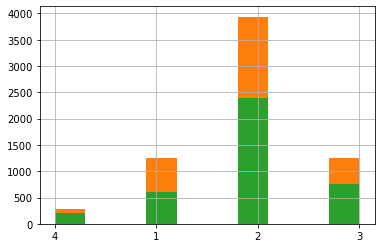

In [76]:
col_info(test.mileagePerYear)
col_info(train.mileagePerYear)
col_info(avito.mileagePerYear)

## age

In [77]:
train['age']=train['age'].astype('int32')
test['age']=test['age'].astype('int32')
avito['age']=avito['age'].astype('int32')

Количество пропусков: 0,
count    3955.000000
mean        9.137042
std         6.467844
min         1.000000
25%         5.000000
50%         8.000000
75%        12.000000
max        82.000000
Name: age, dtype: float64,
Распределение:
7     367
8     323
9     305
12    279
3     270
1     252
6     249
4     240
5     217
2     211
10    206
13    174
11    153
16     95
15     86
22     84
14     82
17     66
18     62
21     46
19     44
23     29
20     22
24     15
27     10
28      9
26      9
30      9
29      6
31      6
25      5
32      4
42      4
37      4
33      3
39      2
82      2
72      2
34      1
36      1
40      1
Name: age, dtype: int64,
Количество пропусков: 0,
count    6706.000000
mean        9.817030
std         6.446504
min         1.000000
25%         5.000000
50%         9.000000
75%        13.000000
max        38.000000
Name: age, dtype: float64,
Распределение:
7     596
9     565
8     561
12    486
1     441
10    381
2     361
6     344
3     337
11   

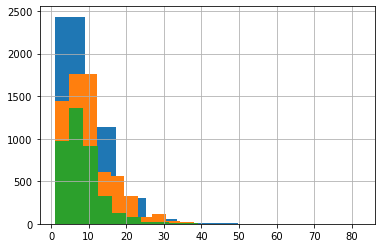

In [78]:
col_info(avito.age)
col_info(train.age)
col_info(test.age)

Для данных с авто.ру мы сделали предварительную работу - убрали пропуски и привели возраст машин к одному диапазону.
Избавимся от выбросов в выборке с автору.

In [79]:
age_outliners_free = outliers_iqr(test.age)

Медиана: 7.0, 25-й перцентиль: 4.0, 75-й перцентиль: 10.0, IQR: 6.0,  Границы выбросов: [-5.0, 19.0].


Сколько значений являются выбросами?

In [80]:
print(len(avito[avito.age > 19]))
print(len(train[train.age > 19]))
print(len(test[test.age > 19]))

274
572
130


Довольно много. Сделаем этот признак категориальным и присвоим всем автомобилям старше 19 лет категорию "20".

In [81]:
avito['age'] = avito['age'].apply(lambda x: 20 if x > 19 else x)
train['age'] = train['age'].apply(lambda x: 20 if x > 19 else x)
test['age'] = test['age'].apply(lambda x: 20 if x > 19 else x)

In [82]:
avito['age']=avito['age'].astype('str')
train['age']=train['age'].astype('str')
test['age']=test['age'].astype('str')

## bodyType

Количество пропусков: 0,
count      3955
unique        7
top       sedan
freq       1745
Name: bodyType, dtype: object,
Распределение:
sedan        1745
SUV          1643
hatchback     262
coupe         212
cabriolet      46
wagon          42
van             5
Name: bodyType, dtype: int64,
Количество пропусков: 0,
count      6706
unique        9
top       sedan
freq       3038
Name: bodyType, dtype: object,
Распределение:
sedan        3038
SUV          2696
coupe         338
hatchback     305
liftback      159
wagon          82
cabriolet      57
roadster       26
van             5
Name: bodyType, dtype: int64,
Количество пропусков: 0,
count     3837
unique       9
top        SUV
freq      1626
Name: bodyType, dtype: object,
Распределение:
SUV          1626
sedan        1595
coupe         214
hatchback     199
liftback      125
wagon          46
cabriolet      19
roadster       10
van             3
Name: bodyType, dtype: int64,


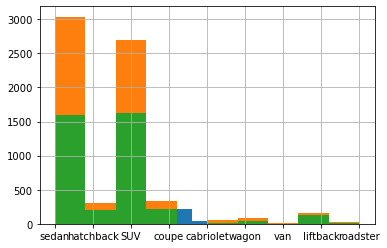

In [83]:
col_info(avito.bodyType)
col_info(train.bodyType)
col_info(test.bodyType)

В выборке авито нет лифтбеков, но пока пропустим этот момент.

## color

Количество пропусков: 4,
count      3951
unique       14
top       black
freq       1659
Name: color, dtype: object,
Распределение:
black        1659
white         605
grey          516
dark_blue     495
silver        181
brown         145
red           139
biege          77
green          64
blue           48
purple          9
violet          7
orange          5
yellow          1
Name: color, dtype: int64,
Количество пропусков: 0,
count      6706
unique       15
top       black
freq       2719
Name: color, dtype: object,
Распределение:
black        2719
white        1127
dark_blue     842
grey          780
silver        422
brown         256
red           199
green         103
blue           71
biege          59
purple         39
golden         38
orange         27
violet         20
yellow          4
Name: color, dtype: int64,
Количество пропусков: 0,
count      3837
unique       15
top       black
freq       1395
Name: color, dtype: object,
Распределение:
black        1395
white     

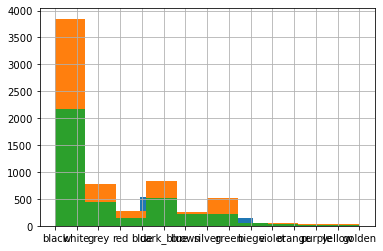

In [84]:
col_info(avito.color)
col_info(train.color)
col_info(test.color)

Заменим 4 пропуска на черный цвет.

In [85]:
avito.color = avito.color.fillna('black')

ОК

## drive

Количество пропусков: 0,
count     3955
unique       3
top        4wd
freq      2358
Name: drive, dtype: object,
Распределение:
4wd    2358
rwd    1577
fwd      20
Name: drive, dtype: int64,
Количество пропусков: 0,
count     6706
unique       3
top        4wd
freq      3871
Name: drive, dtype: object,
Распределение:
4wd    3871
rwd    2814
fwd      21
Name: drive, dtype: int64,
Количество пропусков: 0,
count     3837
unique       3
top        4wd
freq      2444
Name: drive, dtype: object,
Распределение:
4wd    2444
rwd    1378
fwd      15
Name: drive, dtype: int64,


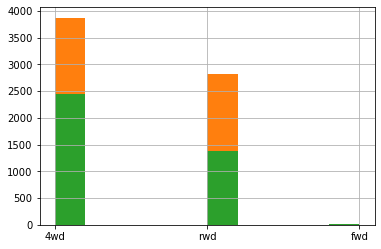

In [86]:
col_info(avito.drive)
col_info(train.drive)
col_info(test.drive)

ОК

## engineDisplacement

Количество пропусков: 0,
count    3955.000000
mean        2.737623
std         0.836434
min         1.500000
25%         2.000000
50%         3.000000
75%         3.000000
max         6.600000
Name: engineDisplacement, dtype: float64,
Распределение:
3.0    1534
2.0    1262
2.5     347
4.4     344
1.6     177
4.8      65
1.5      42
2.8      35
5.0      31
2.2      24
4.0      17
1.8      12
3.6      12
2.9      11
3.5      11
6.0      10
4.9       6
5.4       4
1.9       4
6.6       3
3.4       2
4.6       1
3.2       1
Name: engineDisplacement, dtype: int64,
Количество пропусков: 0,
count    6706.000000
mean        2.696988
std         0.831302
min         1.500000
25%         2.000000
50%         2.500000
75%         3.000000
max         6.600000
Name: engineDisplacement, dtype: float64,
Распределение:
3.0    2395
2.0    2332
4.4     607
2.5     554
1.6     276
4.8     130
2.2      71
1.5      69
1.8      56
2.8      51
1.9      31
4.0      30
3.5      18
5.0      15
2.9      14
3.4 

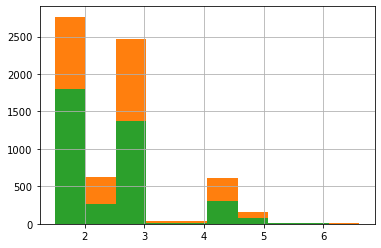

In [87]:
col_info(avito.engineDisplacement)
col_info(train.engineDisplacement)
col_info(test.engineDisplacement)

Данный признак можно отнести к категориальным. Момент спорный, но попробуем сделать так. Изменим тип значений на str.

In [88]:
avito['engineDisplacement']=avito['engineDisplacement'].astype('str')
test['engineDisplacement']=test['engineDisplacement'].astype('str')
train['engineDisplacement']=train['engineDisplacement'].astype('str')

## enginePower

Количество пропусков: 0,
count    3955.000000
mean      248.117067
std        94.640131
min        46.000000
25%       184.000000
50%       231.000000
75%       286.000000
max       625.000000
Name: enginePower, dtype: float64,
Распределение:
184    479
249    344
306    324
218    294
190    271
      ... 
269      1
188      1
510      1
347      1
362      1
Name: enginePower, Length: 68, dtype: int64,
Количество пропусков: 0,
count    6706.000000
mean      242.927080
std        94.818842
min        75.000000
25%       184.000000
50%       231.000000
75%       286.000000
max       625.000000
Name: enginePower, dtype: float64,
Распределение:
184    813
306    457
249    441
218    432
245    415
      ... 
480      1
75       1
610      1
230      1
449      1
Name: enginePower, Length: 78, dtype: int64,
Количество пропусков: 0,
count    3837.000000
mean      242.545739
std        91.429294
min        90.000000
25%       184.000000
50%       231.000000
75%       272.000000
max       

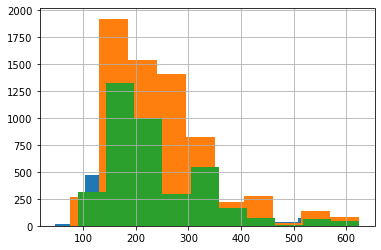

In [89]:
col_info(avito.enginePower)
col_info(train.enginePower)
col_info(test.enginePower)

Видим, что у нас довольно много различных значений. Объединим значения в категории. Переведем значения в int:

In [90]:
avito['enginePower']=avito['enginePower'].astype('int32')
test['enginePower']=test['enginePower'].astype('int32')
train['enginePower']=train['enginePower'].astype('int32')

Напишем функцию, разбивающую мощность двигателя на категории:

In [91]:
def cat_engine_power(x):
    if x < 120: x = 1
    elif 119 < x < 150: x = 2
    elif 149 < x < 180: x = 3
    elif 179 < x < 200: x = 4
    elif 199 < x < 250: x = 5
    elif 249 < x < 300: x = 6
    elif 299 < x < 350: x = 7
    elif 349 < x < 400: x = 8
    elif 399 < x < 450: x = 9
    elif 449 < x < 500: x = 10
    elif 499 < x < 550: x = 11
    elif 549 < x < 600: x = 12
    elif 599 < x: x = 13
    return x      

Применим функцию к тестовой и тренировочной выборкам и переведем значения в str.

In [92]:
avito['enginePower'] = avito['enginePower'].apply(lambda x: cat_engine_power(x))
train['enginePower'] = train['enginePower'].apply(lambda x: cat_engine_power(x))
test['enginePower'] = test['enginePower'].apply(lambda x: cat_engine_power(x))

In [93]:
avito['enginePower']=avito['enginePower'].astype('str')
test['enginePower']=test['enginePower'].astype('str')
train['enginePower']=train['enginePower'].astype('str')

## Equipment - в результате не стали использовать этот признак т.к. не везде собрали данные, но удалять труд было жалко

Чтобы не запутаться в обработке данного признака, пропишем последовательность действий:
* Тестовая выборка: смотрим на значение признака
* Тестовая выборка: собираем все возможные варианты фичей
* Тестовая выборка: меняем значения с того что есть на список фичей для каждого автомобиля
* Автору выборка: смотрим на значение признака
* Автору выборка: собираем все возможные варианты фичей
* Автору выборка: меняем значения с того что есть на список фичей для каждого автомобиля
* Автору выборка: т.к. фичей очень много, отберем только те, которые сильно коррелируют с целевой переменной
* Делаем список значимых фичей из тестовой выборки
* Делаем словарь для дальнейшего переименования значимых фичей
* Оставим только значимые фичи в тестовой и тренировочной выборке, предварительно переименовав фичи в тестовой выборке
* Сделаем dummy переменные для значимых фич для тестовой и тренировочной выборки

Для начала посмотрим на тестовую выборку.

In [94]:
test.equipment[0]

'[\'[{"name":"Безопасность","values":["Антипробуксовочная система (ASR)","Система стабилизации (ESP)","Подушка безопасности водителя","Крепление детского кресла (задний ряд) ISOFIX","Подушки безопасности оконные (шторки)","Подушка безопасности пассажира","Подушки безопасности боковые задние","Подушки безопасности боковые","Датчик давления в шинах","Антиблокировочная система (ABS)","Блокировка замков задних дверей","Подушка безопасности для защиты коленей водителя"]},{"name":"Комфорт","values":["Система «старт-стоп»","Электростеклоподъёмники передние","Мультифункциональное рулевое колесо","Прикуриватель и пепельница","Бортовой компьютер","Усилитель руля","Электропривод зеркал","Электростеклоподъёмники задние","Парктроник передний","Регулировка руля по вылету","Климат-контроль 2-зонный","Электроскладывание зеркал","Парктроник задний"]},{"name":"Мультимедиа","values":["AUX","USB","Аудиосистема","Bluetooth"]},{"name":"Обзор","values":["Датчик света","Автоматический корректор фар","Омывател

Напишем функцию, которая сделает полный список всех возможных фич в тестовой выборке.

In [95]:
def get_test_features(equipment):
    # Создаем пустой список, в который будут добавляться все фичи
    all_features = []
    for data in equipment:
        # Находим все слова между кавычками
        features=re.findall(r'\"(.+?)\"',data)
        # Добавляем в общий список
        all_features.extend(features)
    # Удаляем дубликаты
    all_features = list(dict.fromkeys(all_features))
    return all_features

Посмотрим на результат выполнения функции

In [96]:
test_features = get_test_features(test.equipment)
# Удаляем лишние записи
for bad_feature in ['name','Безопасность','values','Комфорт','Мультимедиа','Обзор','Салон','Защита от угона','Элементы экстерьера']:
    test_features.remove(bad_feature)    
print('Всего уникальных фич:', len(test_features))
print(test_features)

Всего уникальных фич: 170
['Антипробуксовочная система (ASR)', 'Система стабилизации (ESP)', 'Подушка безопасности водителя', 'Крепление детского кресла (задний ряд) ISOFIX', 'Подушки безопасности оконные (шторки)', 'Подушка безопасности пассажира', 'Подушки безопасности боковые задние', 'Подушки безопасности боковые', 'Датчик давления в шинах', 'Антиблокировочная система (ABS)', 'Блокировка замков задних дверей', 'Подушка безопасности для защиты коленей водителя', 'Система «старт-стоп»', 'Электростеклоподъёмники передние', 'Мультифункциональное рулевое колесо', 'Прикуриватель и пепельница', 'Бортовой компьютер', 'Усилитель руля', 'Электропривод зеркал', 'Электростеклоподъёмники задние', 'Парктроник передний', 'Регулировка руля по вылету', 'Климат-контроль 2-зонный', 'Электроскладывание зеркал', 'Парктроник задний', 'AUX', 'USB', 'Аудиосистема', 'Bluetooth', 'Датчик света', 'Автоматический корректор фар', 'Омыватель фар', 'Датчик дождя', 'Электрообогрев боковых зеркал', 'Светодиодные ф

Заменим значение параметра equipment в тестовой выборке на список фич.

In [97]:
def get_features_test(equipment): 
    features=re.findall(r'\"(.+?)\"',equipment)  
    return features

Сейчас в поле equipment будут попадать лишние записи, например, 'name','values' и т.д. Нам это не помешает.

In [98]:
test['equipment'] = test['equipment'].apply(lambda x: get_features_test(x))

Посмотрим теперь на внешние данные

In [99]:
train.equipment[1]

"['cruise-control', 'esp', 'airbag-driver', 'aux', 'isofix', 'electro-window-front', 'light-sensor', 'multi-wheel', 'hcc', 'xenon', 'airbag-passenger', 'computer', 'seat-transformation', 'passenger-seat-electric', 'lock', 'light-cleaner', 'servo', 'electro-mirrors', 'electro-window-back', 'paint-metallic', 'ptf', 'rain-sensor', 'airbag-side', 'mirrors-heat', 'tyre-pressure', 'park-assist-f', 'audiosystem-cd', 'leather', 'wheel-heat', 'abs', 'front-seats-heat', 'wheel-leather', 'wheel-configuration2', 'wheel-configuration1', 'immo', 'climate-control-1', 'auto-mirrors', 'park-assist-r']"

Напишем функцию, которая создаст список фич для тренировочной выборки.

In [100]:
def get_autoru_features(equipment):
    # Создаем пустой список, в который будут добавляться все фичи
    autoru_features = []
    for data in equipment:
        # Находим все слова между кавычками
        features=re.findall(r'\'(.+?)\'',data)
        # Добавляем в общий список
        autoru_features.extend(features)
    # Удаляем дубликаты
    autoru_features = list(dict.fromkeys(autoru_features))
    return autoru_features

Посмотрим на результат.

In [101]:
autoru_features = get_autoru_features(train.equipment)  
print('Всего уникальных фич:', len(autoru_features))
print(autoru_features)

Всего уникальных фич: 302
['cruise-control', 'esp', 'airbag-driver', 'aux', 'isofix', 'electro-window-front', 'light-sensor', 'multi-wheel', 'hcc', 'xenon', 'airbag-passenger', 'computer', 'seat-transformation', 'passenger-seat-electric', 'lock', 'light-cleaner', 'servo', 'electro-mirrors', 'electro-window-back', 'paint-metallic', 'ptf', 'rain-sensor', 'airbag-side', 'mirrors-heat', 'tyre-pressure', 'park-assist-f', 'audiosystem-cd', 'leather', 'wheel-heat', 'abs', 'front-seats-heat', 'wheel-leather', 'wheel-configuration2', 'wheel-configuration1', 'immo', 'climate-control-1', 'auto-mirrors', 'park-assist-r', 'massage-seats', 'navigation', 'keyless-entry', 'start-button', 'entertainment-system-for-rear-seat-passengers', 'tinted-glass', 'sport-seats', 'usb', 'e-adjustment-wheel', 'ashtray-and-cigarette-lighter', 'front-centre-armrest', 'decorative-interior-lighting', 'roof-rails', 'door-sill-panel', 'volume-sensor', 'power-latching-doors', 'dark-interior', 'body-mouldings', 'folding-fro

Итого у нас 302 фичи с авто.ру и 170 из тестовой выборки. Можно сделать словарь из 170 записей, но это довольно рутинная работа. Сделаем для этого параметра в тренировочной выборки dummy-переменные и, на основе корреляционного анализа, выберем самые значимые фичи.

Для начала преобразуем признак для выборки с авто.ру в список (сейчас он идет сплошным текстом).
Напишем функцию.

In [102]:
def get_features_train(equipment):      
    features=re.findall(r'\'(.+?)\'',equipment)
    return features

Применим функцию для тренировочного датасета.

In [103]:
train['equipment'] = train['equipment'].apply(lambda x: get_features_train(x))

In [104]:
train.equipment[1]

['cruise-control',
 'esp',
 'airbag-driver',
 'aux',
 'isofix',
 'electro-window-front',
 'light-sensor',
 'multi-wheel',
 'hcc',
 'xenon',
 'airbag-passenger',
 'computer',
 'seat-transformation',
 'passenger-seat-electric',
 'lock',
 'light-cleaner',
 'servo',
 'electro-mirrors',
 'electro-window-back',
 'paint-metallic',
 'ptf',
 'rain-sensor',
 'airbag-side',
 'mirrors-heat',
 'tyre-pressure',
 'park-assist-f',
 'audiosystem-cd',
 'leather',
 'wheel-heat',
 'abs',
 'front-seats-heat',
 'wheel-leather',
 'wheel-configuration2',
 'wheel-configuration1',
 'immo',
 'climate-control-1',
 'auto-mirrors',
 'park-assist-r']

Создадим dummy variables для фич. Проделаем эту работу на копии датасета с автру, чтобы не портить оригинал.

In [105]:
train_equipment = train.copy()
# Функция для отображения фич в записи
def find_item(cell):
    if item in cell:
        return 1
    return 0
# Создаем набор фич
features = set()
for featurelist in train_equipment['equipment']:
    for feature in featurelist:
        features.add(feature)
# Cоздаем столбцы с фичами и заполняем 0 или 1
for item in features:
    train_equipment[item] = train_equipment['equipment'].apply(find_item)

In [106]:
train_equipment.columns

Index(['age', 'bodyType', 'color', 'drive', 'engineDisplacement',
       'enginePower', 'equipment', 'fuelType', 'mileage', 'modelAge',
       ...
       'hcc', 'decorative-interior-lighting', 'wheel-memory',
       'rear-seats-heat', 'dha', 'auto-mirrors', 'isofix',
       'easy-trunk-opening', '6WB', '5DL'],
      dtype='object', length=328)

Сделаем отбор фич с коэффициентом корреляции > 0.3

In [107]:
cor_target = abs(train_equipment.corr()["price"])
relevant_features = cor_target[cor_target>0.3] # Выбираем фичи с значением модуля коэффициента корреляции > 0.3
relevant_features

mileage                         0.623069
modelAge                        0.617450
owners                          0.545860
acceleration                    0.526876
taxPrice                        0.477374
price                           1.000000
bas                             0.359198
high-beam-assist                0.476486
activ-suspension                0.374009
360-camera                      0.307831
music-super                     0.486399
air-suspension                  0.382889
rain-sensor                     0.326041
auto-park                       0.509524
tyre-pressure                   0.345767
servo                           0.379322
projection-display              0.367014
keyless-entry                   0.490653
navigation                      0.397949
start-button                    0.342382
third-row-seats                 0.304601
body-kit                        0.415669
glonass                         0.479678
passenger-seat-electric         0.309734
front-seats-heat

Создадим список значимых  фич. Некоторые фичи не включаем т.к. не нашлось аналога в тестовой выборке.

In [108]:
equipment_list = [
    'high-beam-assist',
    'front-seats-heat-vent',
    'bluetooth',
    'laser-lights',
    'light-sensor',
    'adaptive-light',
    'apple-carplay',
    'electro-trunk',
    'third-row-seats',
    'keyless-entry',
    'activ-suspension',
    'multizone-climate-control',
    'body-kit',
    'projection-display',
    'start-stop-function',
    'start-button',
    'paint-metallic',
    'wheel-heat',
    'passenger-seat-electric',
    'rain-sensor',
    'navigation',
    'voice-recognition',
    'multi-wheel',
    'airbag-curtain',
    'glonass',
    'auto-mirrors',
    'usb',
    'power-latching-doors',
    'led-lights',
    'auto-park',
    'bas',
    'isofix',
    'tyre-pressure',
    'air-suspension',
    'decorative-interior-lighting',
    '360-camera',
    'wireless-charger',
    'electronic-gage-panel',
]

Создадим словарь для замены фич в тестовой выборке

In [109]:
equipment_dict = {
    'Система управления дальним светом': 'high-beam-assist',
    'Вентиляция передних сидений': 'front-seats-heat-vent',
    'Bluetooth': 'bluetooth',
    'Лазерные фары': 'laser-lights',
    'Датчик света': 'light-sensor',
    'Система адаптивного освещения': 'adaptive-light',
    'CarPlay': 'apple-carplay',
    'Электропривод крышки багажника': 'electro-trunk',
    'Третий ряд сидений': 'third-row-seats',
    'Система доступа без ключа': 'keyless-entry',
    'Активная подвеска': 'activ-suspension',
    'Климат-контроль многозонный': 'multizone-climate-control',
    'Обвес кузова': 'body-kit',
    'Проекционный дисплей': 'projection-display',
    'Система «старт-стоп»': 'start-stop-function',
    'Запуск двигателя с кнопки': 'start-button',
    'Металлик': 'paint-metallic',
    'Обогрев рулевого колеса': 'wheel-heat',
    'Электрорегулировка передних сидений': 'passenger-seat-electric',
    'Датчик дождя': 'rain-sensor',
    'Навигационная система': 'navigation',
    'Голосовое управление': 'voice-recognition',
    'Мультифункциональное рулевое колесо': 'multi-wheel',
    'Подушки безопасности оконные (шторки)': 'airbag-curtain',
    'ЭРА-ГЛОНАСС': 'glonass',
    'Электроскладывание зеркал': 'auto-mirrors',
    'USB': 'usb',
    'Доводчик дверей': 'power-latching-doors',
    'Светодиодные фары': 'led-lights',
    'Система автоматической парковки': 'auto-park',
    'Система помощи при торможении (BAS, EBD)': 'bas',
    'Крепление детского кресла (передний ряд) ISOFIX': 'isofix',
    'Датчик давления в шинах': 'tyre-pressure',
    'Пневмоподвеска': 'air-suspension',
    'Декоративная подсветка салона': 'decorative-interior-lighting',
    'Камера 360°': '360-camera',
    'Беспроводная зарядка для смартфона': 'wireless-charger',
    'Электронная приборная панель': 'electronic-gage-panel',
}

Заменим название значимых фич в тестовой выборке. Незначимые фичи оставим без изменений.

In [110]:
def test_feature_change(x):
    x = [equipment_dict.get(a) if equipment_dict.get(a) else a for a in x]
    return x

In [111]:
test['equipment'] = test['equipment'].apply(lambda x: test_feature_change(x))

Удалим из признака equipment все фичи кроме значимых для тестовой и тренировочной выборки.

In [112]:
def main_feature(x):
    super_features = []
    for equipment in x:
        if equipment in equipment_list:
            super_features.append(equipment)
    x = super_features
    return x

In [113]:
test['equipment'] = test['equipment'].apply(lambda x: main_feature(x))
train['equipment'] = train['equipment'].apply(lambda x: main_feature(x))

Создадим dummy-переменные для тестовой и тренировочной выборки # Пока не делаем т.к. не взяли эту информацию с авито.

In [114]:
#for item in equipment_list:
#    train[item] = train['equipment'].apply(find_item)

In [115]:
#for item in equipment_list:
#    test[item] = test['equipment'].apply(find_item)

Таким образом мы получили dummy-переменные с наиболее коррелирующими с целевой переменной фичами автомобиля. Удалим столбец equipment.

In [116]:
avito = avito.drop('equipment', axis=1)
test = test.drop('equipment', axis=1)
train = train.drop('equipment', axis=1)

## fuelType

Количество пропусков: 0,
count       3955
unique         4
top       petrol
freq        2575
Name: fuelType, dtype: object,
Распределение:
petrol     2575
diesel     1375
hybrid        3
electro       2
Name: fuelType, dtype: int64,
Количество пропусков: 0,
count       6706
unique         3
top       petrol
freq        4585
Name: fuelType, dtype: object,
Распределение:
petrol    4585
diesel    2108
hybrid      13
Name: fuelType, dtype: int64,
Количество пропусков: 0,
count       3837
unique         4
top       petrol
freq        2471
Name: fuelType, dtype: object,
Распределение:
petrol     2471
diesel     1358
hybrid        7
electro       1
Name: fuelType, dtype: int64,


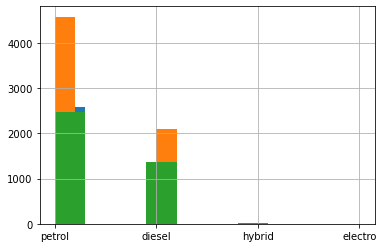

In [117]:
col_info(avito.fuelType)
col_info(train.fuelType)
col_info(test.fuelType)

ОК

## mileage

In [118]:
avito['mileage']=avito['mileage'].astype('int32')
test['mileage']=test['mileage'].astype('int32')
train['mileage']=train['mileage'].astype('int32')

Количество пропусков: 0,
count      3955.000000
mean     138748.911504
std       90558.913974
min          11.000000
25%       77777.000000
50%      124335.000000
75%      191100.000000
max      602000.000000
Name: mileage, dtype: float64,
Распределение:
200000    63
170000    44
105000    35
300000    34
150000    34
          ..
8375       1
55468      1
159        1
135305     1
102402     1
Name: mileage, Length: 1080, dtype: int64,
Количество пропусков: 0,
count       6706.000000
mean      148929.647927
std       100153.193433
min            0.000000
25%        78528.000000
50%       135000.000000
75%       200000.000000
max      1000000.000000
Name: mileage, dtype: float64,
Распределение:
0         147
200000     76
160000     74
150000     71
300000     68
         ... 
177284      1
48265       1
159         1
171153      1
120861      1
Name: mileage, Length: 2297, dtype: int64,
Количество пропусков: 0,
count       3837.000000
mean      118536.361480
std        85125.949826
mi

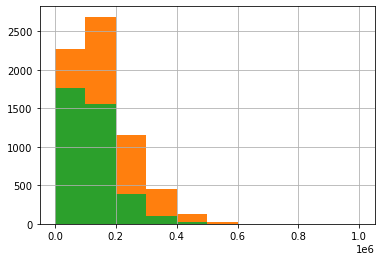

In [119]:
col_info(avito.mileage)
col_info(train.mileage)
col_info(test.mileage)

Заменим текущие значения на категории с разбивкой по 25 тыс.км. Автомобили с пробегом более 400 тыс.км. объединим в одну категорию.

In [120]:
def cat_mileage(x):
    if x < 25000: x = 1
    elif 25000 <= x < 50000: x = 2
    elif 50000 <= x < 75000: x = 3
    elif 75000 <= x < 100000: x = 4
    elif 100000 <= x < 125000: x = 5
    elif 125000 <= x < 150000: x = 6
    elif 150000 <= x < 175000: x = 7
    elif 175000 <= x < 200000: x = 8
    elif 200000 <= x < 225000: x = 9
    elif 225000 <= x < 250000: x = 10
    elif 250000 <= x < 275000: x = 11
    elif 275000 <= x < 300000: x = 12
    elif 300000 <= x < 325000: x = 13
    elif 325000 <= x < 350000: x = 14
    elif 350000 <= x < 375000: x = 15
    elif 375000 <= x < 400000: x = 16
    elif 400000 <= x: x = 17
    return x      

In [121]:
avito['mileage'] = avito['mileage'].apply(lambda x: cat_mileage(x))
test['mileage'] = test['mileage'].apply(lambda x: cat_mileage(x))
train['mileage'] = train['mileage'].apply(lambda x: cat_mileage(x))
avito['mileage'] = avito['mileage'].astype('str')
test['mileage'] = test['mileage'].astype('str')
train['mileage'] = train['mileage'].astype('str')

## modelAge

In [122]:
avito['modelAge']=avito['modelAge'].astype('int32')
test['modelAge']=test['modelAge'].astype('int32')
train['modelAge']=train['modelAge'].astype('int32')

Количество пропусков: 0,
count    3955.000000
mean       11.177244
std         6.666011
min         1.000000
25%         7.000000
50%        10.000000
75%        14.000000
max        84.000000
Name: modelAge, dtype: float64,
Распределение:
7     398
13    324
6     316
11    285
9     271
12    255
14    234
10    227
5     226
8     214
4     178
15    134
17    118
22    100
3      99
25     95
2      93
18     78
19     77
20     42
21     33
16     31
30     27
32     25
26     24
1      21
38      5
31      5
45      4
39      4
43      4
44      3
83      2
84      2
34      1
Name: modelAge, dtype: int64,
Количество пропусков: 0,
count    6706.000000
mean       11.857739
std         6.825035
min         1.000000
25%         7.000000
50%        11.000000
75%        14.000000
max        45.000000
Name: modelAge, dtype: float64,
Распределение:
13    619
11    589
7     504
14    465
9     455
5     367
12    349
8     346
10    342
6     337
4     285
15    252
17    252
25    216


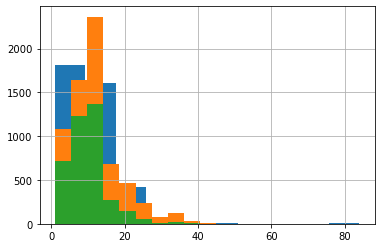

In [123]:
col_info(avito.modelAge)
col_info(train.modelAge)
col_info(test.modelAge)

Сделаем ту же процедуру, что и с признаком 'age': сделаем признак категориальным, все модели старше 19 лет положим в одну категорию.

In [124]:
avito['modelAge'] = avito['modelAge'].apply(lambda x: 20 if x > 19 else x)
train['modelAge'] = train['modelAge'].apply(lambda x: 20 if x > 19 else x)
test['modelAge'] = test['modelAge'].apply(lambda x: 20 if x > 19 else x)
avito['modelAge'] = avito['modelAge'].astype('str')
test['modelAge'] = test['modelAge'].astype('str')
train['modelAge'] = train['modelAge'].astype('str')

## name - пока оставим

## numberOfDoors

Сделаем признак категориальным.

In [125]:
avito['numberOfDoors']=avito['numberOfDoors'].astype('str')
test['numberOfDoors']=test['numberOfDoors'].astype('str')
train['numberOfDoors']=train['numberOfDoors'].astype('str')

Количество пропусков: 0,
count     3955
unique       4
top          5
freq      1919
Name: numberOfDoors, dtype: object,
Распределение:
5    1919
4    1739
2     264
3      33
Name: numberOfDoors, dtype: int64,
Количество пропусков: 0,
count     6706
unique       4
top          5
freq      3175
Name: numberOfDoors, dtype: object,
Распределение:
5    3175
4    3037
2     422
3      72
Name: numberOfDoors, dtype: int64,
Количество пропусков: 0,
count     3837
unique       4
top          5
freq      1963
Name: numberOfDoors, dtype: object,
Распределение:
5    1963
4    1594
2     244
3      36
Name: numberOfDoors, dtype: int64,


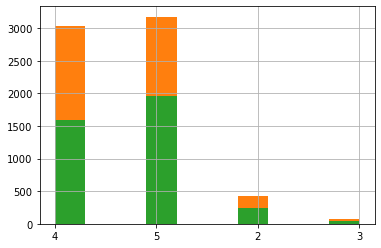

In [126]:
col_info(avito.numberOfDoors)
col_info(train.numberOfDoors)
col_info(test.numberOfDoors)

ОК

## owners

Сделаем категориальным

In [127]:
avito['owners']=avito['owners'].astype('int32')
test['owners']=test['owners'].astype('int32')
train['owners']=train['owners'].astype('int32')

In [128]:
avito['owners']=avito['owners'].astype('str')
test['owners']=test['owners'].astype('str')
train['owners']=train['owners'].astype('str')

Количество пропусков: 0,
count     3955
unique       3
top          3
freq      1701
Name: owners, dtype: object,
Распределение:
3    1701
1    1228
2    1026
Name: owners, dtype: int64,
Количество пропусков: 0,
count     6706
unique       3
top          3
freq      3295
Name: owners, dtype: object,
Распределение:
3    3295
2    1749
1    1662
Name: owners, dtype: int64,
Количество пропусков: 0,
count     3837
unique       3
top          3
freq      1516
Name: owners, dtype: object,
Распределение:
3    1516
1    1309
2    1012
Name: owners, dtype: int64,


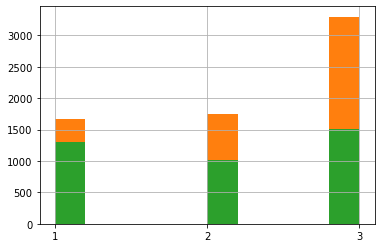

In [129]:
col_info(avito.owners)
col_info(train.owners)
col_info(test.owners)

## technicalPassport

In [130]:
avito['technicalPassport']=avito['technicalPassport'].astype('int32')
test['technicalPassport']=test['technicalPassport'].astype('int32')
train['technicalPassport']=train['technicalPassport'].astype('int32')
avito['technicalPassport']=avito['technicalPassport'].astype('str')
test['technicalPassport']=test['technicalPassport'].astype('str')
train['technicalPassport']=train['technicalPassport'].astype('str')

Количество пропусков: 0,
count     3955
unique       2
top          1
freq      3942
Name: technicalPassport, dtype: object,
Распределение:
1    3942
0      13
Name: technicalPassport, dtype: int64,
Количество пропусков: 0,
count     6706
unique       2
top          1
freq      5702
Name: technicalPassport, dtype: object,
Распределение:
1    5702
0    1004
Name: technicalPassport, dtype: int64,
Количество пропусков: 0,
count     3837
unique       2
top          1
freq      3463
Name: technicalPassport, dtype: object,
Распределение:
1    3463
0     374
Name: technicalPassport, dtype: int64,


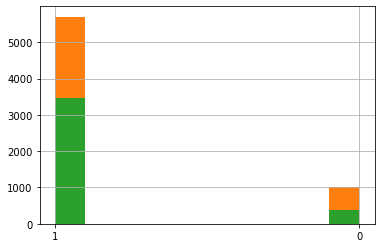

In [131]:
col_info(avito.technicalPassport)
col_info(train.technicalPassport)
col_info(test.technicalPassport)

ОК

## vehicleTransmission

Количество пропусков: 0,
count     3955
unique       3
top         AT
freq      3719
Name: vehicleTransmission, dtype: object,
Распределение:
AT    3719
MT     194
AM      42
Name: vehicleTransmission, dtype: int64,
Количество пропусков: 0,
count     6706
unique       3
top         AT
freq      6175
Name: vehicleTransmission, dtype: object,
Распределение:
AT    6175
MT     459
AM      72
Name: vehicleTransmission, dtype: int64,
Количество пропусков: 0,
count     3837
unique       3
top         AT
freq      3677
Name: vehicleTransmission, dtype: object,
Распределение:
AT    3677
MT     111
AM      49
Name: vehicleTransmission, dtype: int64,


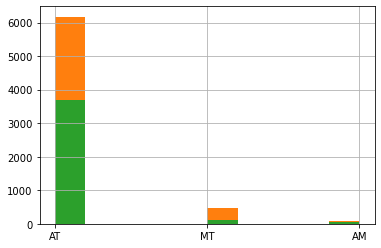

In [132]:
col_info(avito.vehicleTransmission)
col_info(train.vehicleTransmission)
col_info(test.vehicleTransmission)

ОК

## name

Для начала посмотрим, какие данные хранятся в этом признаке в тестовой и тренировочной выборках.

In [133]:
sorted(avito.name.unique())

['116i',
 '118d',
 '118i',
 '120d',
 '120i',
 '123d',
 '125i',
 '18d',
 '18i',
 '20d',
 '20i',
 '216d',
 '218d',
 '218i',
 '220d',
 '220i',
 '23i',
 '25d',
 '25i',
 '28i',
 '30d',
 '30i',
 '316i',
 '318d',
 '318i',
 '320d',
 '320i',
 '323i',
 '325i',
 '325xi',
 '328i',
 '330i',
 '330xi',
 '335i',
 '335xi',
 '340i',
 '35d',
 '35i',
 '35is',
 '40d',
 '40i',
 '420d',
 '420i',
 '428i',
 '430i',
 '435i',
 '48i',
 '50i',
 '518i',
 '520',
 '520Li',
 '520d',
 '520i',
 '523i',
 '525d',
 '525i',
 '525xd',
 '525xi',
 '528i',
 '530d',
 '530i',
 '530xi',
 '535d',
 '535i',
 '540i',
 '545i',
 '550i',
 '630d',
 '630i',
 '635i',
 '640d',
 '640i',
 '645i',
 '650i',
 '725Ld',
 '728i',
 '730Ld',
 '730Li',
 '730d',
 '730i',
 '733i',
 '735Li',
 '735i',
 '740Ld',
 '740Li',
 '740d',
 '740i',
 '745Li',
 '745d',
 '745i',
 '750Ld',
 '750Li',
 '750d',
 '750i',
 '760Li',
 '760i',
 '840d',
 'ActiveHybrid',
 'M40d',
 'M50d',
 'M550d',
 'M550i',
 'M760Li',
 'M850i',
 'None']

In [134]:
sorted(train.name.unique())

['116',
 '118',
 '120',
 '123',
 '125',
 '130',
 '135',
 '18d',
 '18i',
 '20d',
 '20i',
 '216',
 '218',
 '220',
 '23d',
 '23i',
 '25d',
 '25i',
 '28i',
 '3.0d',
 '3.0i',
 '3.0sd',
 '3.0si',
 '30d',
 '30i',
 '315',
 '316',
 '318',
 '320',
 '323',
 '325',
 '328',
 '330',
 '335',
 '340',
 '35d',
 '35i',
 '35is',
 '4.4i',
 '4.6is',
 '4.8i',
 '4.8is',
 '40d',
 '40e',
 '40i',
 '420',
 '428',
 '430',
 '435',
 '440',
 '48i',
 '50i',
 '518',
 '520',
 '520L',
 '523',
 '524',
 '525',
 '528',
 '528L',
 '530',
 '530L',
 '535',
 '535L',
 '540',
 '545',
 '550',
 '630',
 '635',
 '640',
 '645',
 '650',
 '725',
 '725L',
 '728',
 '728L',
 '730',
 '730L',
 '735',
 '735L',
 '740',
 '740L',
 '745',
 '745L',
 '750',
 '750L',
 '760',
 '760L',
 '840',
 '850',
 'Active Hybrid 7L',
 'ActiveHybrid',
 'Compact',
 'Competition',
 'Gran Coupe',
 'Gran Turismo',
 'I8',
 'M2',
 'M235i',
 'M3',
 'M4',
 'M40d',
 'M40i',
 'M5',
 'M50d',
 'M50i',
 'M550d xDrive',
 'M550i xDrive',
 'M6',
 'M760L',
 'M8',
 'M850',
 'X3_M',


In [135]:
sorted(test.name.unique())

['1.5',
 '1.5hyb',
 '116i',
 '118d',
 '118i',
 '120d',
 '120i',
 '125i',
 '130i',
 '135i',
 '18d',
 '18i',
 '2.0',
 '2.2',
 '20d',
 '20i',
 '218i',
 '220i',
 '23d',
 '23i',
 '25d',
 '25i',
 '28i',
 '3.0',
 '3.0d',
 '3.0i',
 '3.0sd',
 '3.0si',
 '30d',
 '30i',
 '316',
 '316i',
 '318d',
 '318i',
 '320d',
 '320i',
 '323i',
 '325i',
 '325xi',
 '328i',
 '330d',
 '330i',
 '330xd',
 '330xi',
 '335i',
 '335xi',
 '340i',
 '35d',
 '35i',
 '35is',
 '4.0',
 '4.4',
 '4.4i',
 '4.6is',
 '4.8i',
 '4.8is',
 '40d',
 '40i',
 '420d',
 '420i',
 '428i',
 '430i',
 '440i',
 '48i',
 '5.0',
 '50i',
 '518',
 '520Li',
 '520d',
 '520i',
 '523i',
 '525d',
 '525i',
 '525xd',
 '525xi',
 '528Li',
 '528i',
 '530Li',
 '530d',
 '530i',
 '530xd',
 '530xi',
 '535d',
 '535i',
 '540i',
 '545i',
 '550i',
 '620d',
 '630d',
 '630i',
 '640d',
 '640i',
 '645i',
 '650i',
 '725Ld',
 '728i',
 '730Ld',
 '730Li',
 '730d',
 '730i',
 '735Li',
 '735i',
 '740Ld',
 '740Li',
 '740d',
 '740i',
 '745Li',
 '745i',
 '750Ld',
 '750Li',
 '750d',
 

Видим, что данные различаются. Буквы i и d определяют тип топлива, то есть количество вариантов можно сократить и привести к одному виду. Посмотрим, сможем ли мы, имполюзуя признак name, определить модель автомобиля.

In [136]:
train[train.name == '116'].model.value_counts()

1ER    198
Name: model, dtype: int64

In [137]:
train[train.name == '30d'].model.value_counts()

X5    192
X6    165
X3     56
X7     33
X4     20
Name: model, dtype: int64

Видим, что в некоторых случаях модель определяется однозначно, а в некоторых для name есть несколько моделей. Посмотрим, какие признаки, присутствующие в тестовой выборке, различаются у данных моделей.

In [138]:
train_model = train[[
    'age',
    'bodyType',
    'color',
    'drive',
    'engineDisplacement',
    'enginePower',
    'fuelType',
    'mileage',
    'modelAge',
    'name',
    'numberOfDoors',
    'owners',
    'technicalPassport',
    'vehicleTransmission',
    'model',
]]

In [139]:
train_model[train_model.name == '30d']

,age,bodyType,color,drive,engineDisplacement,enginePower,fuelType,mileage,modelAge,name,numberOfDoors,owners,technicalPassport,vehicleTransmission,model
90,10,SUV,black,4wd,3.0,5,diesel,6,14,30d,5,3,1,AT,X5
96,9,SUV,dark_blue,4wd,3.0,5,diesel,8,13,30d,5,3,1,AT,X6
102,9,SUV,dark_blue,4wd,3.0,5,diesel,5,13,30d,5,1,1,AT,X6
121,12,SUV,grey,4wd,3.0,5,diesel,8,14,30d,5,1,1,AT,X5
129,11,SUV,black,4wd,3.0,5,diesel,7,13,30d,5,3,1,AT,X6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6673,5,SUV,black,4wd,3.0,5,diesel,8,6,30d,5,2,1,AT,X6
6680,6,SUV,black,4wd,3.0,5,diesel,5,8,30d,5,2,1,AT,X6
6685,8,SUV,black,4wd,3.0,5,diesel,5,10,30d,5,3,1,AT,X3
6690,1,SUV,grey,4wd,3.0,5,diesel,1,2,30d,5,1,1,AT,X5


Видим, что 30d однозначно определяет тип двигателя, но нам может помочь признак modelAge.

In [140]:
train_model[train.name == '30d'].modelAge.value_counts()

6     93
10    87
2     65
14    59
13    54
7     53
8     32
17    12
3     10
1      1
Name: modelAge, dtype: int64

Посмотрим, сколько моделей соответствует name = 30d и modelAge = 10

In [141]:
train_model[train_model.name == '30d'][train_model.modelAge=='10'].model.value_counts()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


X5    68
X3    19
Name: model, dtype: int64

Видим, что количество вариантов уменьшилось. Создадим словарь, для приведения признака name к одному виду, и в нем же в комментариях пропишем наиболее вероятную модель автомобиля, основываясь на признаках modelAge и name.

In [142]:
dic_name = {
    '1.5': 'default',   # test coupe 1   2ER
    '1.5hyb': '1.5hyb', # test coupe 3 + roadster 2    i8
    '116': '116',   # 1ER
    '116i': '116',  # 1ER 
    '118': '118',  # 1ER
    '118d': '118', # 1ER
    '118i': '118',  # 1ER
    '120': '120',   # 1ER
    '120d': '120',  # 1ER
    '120i': '120',  # 1ER
    '123': '120',   # autoru 1, похож на 120 # 1ER
    '123d': '120', # 1ER
    '125': '125',  # 1ER
    '125i': '125',  # 1ER
    '130': '130',  # 1ER
    '130i': '130',  # 1ER
    '135': '135',  # 1ER
    '135i': '135',  # 1ER
    '18d': '18', # 3y-x2, 5y,11y-x1
    '18i': '18', # 3y-x2, 5y,8y,11y-x1
    '2.0': 'default', # test z4
    '2.2': 'default', # test z4
    '20d': '20', # 2y,5y-x1, 3y-x3,x2, 5y-x1, 6y-x4,x3, 8y-x1, 10y-x3, 11y-x1, 14y-x3 
    '20i': '20', # 1y-x1, 2y-x4, 3y-x3,x2, 5-x1, 6-x3x4, 7-z4, 8-x1, 10-x3, 11-x1,z4 (в зависимости от дверей), 14-x3
    '216': '218', # 2ER
    '216d': 'default', # 2ER
    '218': '218', # 2ER
    '218i': '218', # 2ER
    '218d': '218', # 2ER 
    '220': '220', # 2ER
    '220d': '220', # 2ER
    '220i': '220', # 2ER
    '23d': '23', # X1
    '23i': '23', # Z4
    '25d': '25', # X5
    '25i': '25', # 14y,17y-x3, 11y-x1
    '28i': '28', # 6y-x4,x3, 8y-x1, 10y-x3, 11y-x1
    '3.0': '3.0', # X5
    '3.0d': '3.0', # X5
    '3.0i': '3.0', # X5
    '3.0sd': '3.0s', # X5
    '3.0si': '3.0s', # X5
    '30d': '30', # 1y-x6, 2y-x7,x5,x4, 3y-x3, 6y-x6,x4,x3, 7y-x5, 8y-x6, 10y-x5,x3, 13y-x6, 14y-x5,x3, 17y-x3  
    '30i': '', # 2y-x4, 3y-x3, 11y-z4, 14y-x5,x3, 17y-x3
    '315': '316',   # 3ER - autoru 1
    '316': '316',   # 3ER
    '316i': '316',   # 3ER
    '318': '318',   # 3ER
    '318i': '318',   # 3ER
    '318d': '318',   # 3ER
    '320': '320',   # 3ER
    '320i': '320',   # 3ER
    '320d': '320',   # 3ER
    '323': 'default',   # 3ER
    '323i': 'default',   # 3ER
    '325': '325',   # 3ER
    '325i': '325',   # 3ER
    '325xi': '325',   # 3ER
    '328': '328',   # 3ER
    '328i': '328',   # 3ER
    '330': '330',   # 3ER
    '330i': '330',   # 3ER
    '330d': '330',   # 3ER
    '330xd': '330',   # 3ER
    '330xi': '330',   # 3ER
    '335': '335',   # 3ER
    '335i': '335',   # 3ER
    '335xi': '335',   # 3ER
    '340': '340',   # 3ER
    '340i': '340',   # 3ER
    '35d': '35', # 10y-x5, 13y-x6, 14y-x5,x3
    '35i': '35', # 6y-x6,x4, 7y-x5, 8y-x6, 10y-x5,x3, 11y-z4 , 13y-x6
    '35is': '35', # z4
    '4.0': 'default', # X5
    '4.4': '4.4', # X5
    '4.4i': '4.4', # X5
    '4.6is': '4.6s', # X5
    '4.8i': '4.8', # X5
    '4.8is': '4.8s', # X5
    '40d': '40',# 6y-x6, 7y-x5,8y-x6, 10y-x5, 13y-x6
    '40e': '40',# X5
    '40i': '40', # 1y-x6, 2y-x7,x5
    '420': '420',   # 4
    '420d': '420',   # 4    
    '420i': '420',   # 4    
    '428': '428',   # 4
    '428i': '428',   # 4
    '430': '430',   # 4
    '430i': '430',   # 4
    '435': 'default',   # 4 - нет в тестовой
    '435i': 'default', #4
    '440': '440',   # 4
    '440i': '440',   # 4
    '48i': '48',   # X5
    '5.0': 'default',   # X5
    '50i': '50', #6y-x6, 7y-x5, 8y-x6, 10y-x5, 13y-x6
    '518': '518', # 5ER
    '518i': '518', # 5ER 
    '520': '520', # 5ER
    '520L': '520L', # 5ER
    '520i': '520', # 5ER
    '520d': '520', # 5ER
    '520Li': '520L', # 5ER
    '523': '523', # 5ER
    '523i': '523', # 5ER
    '524': 'default', # 5ER
    '525': '525', # 5ER
    '525i': '525', # 5ER
    '525d': '525', # 5ER
    '525xi': '525x', # 5ER
    '525xd': '525x', # 5ER
    '528': '528', # 5ER
    '528L': '528L', # 5ER
    '528i': '528', # 5ER
    '528Li': '528L', # 5ER
    '530': '530', # 5ER
    '530L': '530L', # 5ER
    '530i': '530', # 5ER
    '530Li': '530L', # 5ER
    '530d': '530', # 5ER
    '530xd': '530x', # 5ER
    '530xi': '530x', # 5ER
    '535': '535', # 5ER
    '535L': 'default', # 5ER
    '535i': '535', # 5ER
    '535d': '535', # 5ER
    '540': '540', # 5ER
    '540i': '540', # 5ER
    '545': '545', # 5ER
    '545i': '545', # 5ER
    '550': '550', # 5ER
    '550i': '550', # 5ER
    '620d': 'default', # 6ER
    '630': '630',# 6ER
    '630i': '630',# 6ER
    '630d': '630',# 6ER
    '635': 'default',# 6ER
    '635i': 'default',# 6ER
    '640': '640',# 6ER
    '640i': '640',# 6ER
    '640d': '640',# 6ER
    '645': '645',# 6ER
    '645i': '645',# 6ER
    '650': '650',# 6ER
    '650i': '650',# 6ER
    '725': 'default',#7ER
    '725L': '725L',# 7ER
    '725Ld': '725L',# 7ER
    '728': '728',# 7ER
    '728i': '728',# 7ER
    '728L': 'default',#7ER
    '730': '730',# 7ER
    '730L': '730L',# 7ER
    '730d': '730',# 7ER
    '730Ld': '730L',# 7ER
    '730i': '730',# 7ER
    '730Li': '730L',# 7ER
    '733i': 'default', # 7ER
    '735': '735',# 7ER
    '735L': '735L',# 7ER
    '735i': '735',# 7ER
    '735Li': '735L',# 7ER
    '740': '740',# 7ER
    '740L': '740L',# 7ER
    '740i': '740',# 7ER
    '740Li': '740L',# 7ER
    '740d': '740',# 7ER
    '740Ld': '740L',# 7ER
    '745': '745',# 7ER
    '745d': '745',# 7ER
    '745L': '745L',# 7ER
    '745i': '745',# 7ER
    '745Li': '745L',# 7ER
    '750': '750',# 7ER
    '750L': '750L',# 7ER
    '750i': '750',# 7ER
    '750Li': '750L',# 7ER
    '750d': '750',# 7ER
    '750Ld': '750L',# 7ER
    '760': '760',# 7ER
    '760L': '760L',# 7ER
    '760i': '760',# 7ER
    '760Li': '760L',# 7ER
    '840': '840', # 8ER
    '840d': '840', # 8ER
    '850': 'default', # 8ER
    'Active Hybrid 7L': 'ActiveHybrid', #autoru # 7ER 1
    'Active': 'default',
    'ActiveHybrid': 'ActiveHybrid', # x6
    'CS': 'M4',  #test - M4 ?
    'Compact': '316', #autoru - 3ER
    'Competition': 'M5', # M5
    'Electro': '1.5hyb', # test - 1
    'Gran Coupe': 'default',#autoru X6
    'Gran Turismo': 'default',#autoru
    'I8': '1.5hyb', #I8
    'M135i': 'default',  # 1ER
    'M2': 'default', #autoru
    'M235i': 'M235',# 2ER
    'M3': 'M3', #autoru #3ER
    'M340i': 'M3', #3ER
    'M4': 'M4', #autoru
    'M40d': 'M40', # 2y-x4, 3y-x3
    'M40i': 'M40',# x4
    'M5': 'M5', #autoru
    'M50d': 'M50', # 1y-x6, 2y-x7,x5, 6y-x6, 7y-x5, 8y-x6 ,10y-x5
    'M50i': 'M50', # x6
    'M550d': 'M550',  #5ER
    'M550i': 'M550',  #5ER
    'M550d xDrive': 'M550', #5ER
    'M550i xDrive': 'M550', #5ER
    'M6': 'default', #autoru
    'M760L': 'M760L', #7ER
    'M760Li': 'M760L', #7ER   
    'M8': 'M850', #8ER
    'M850': 'M850', #8ER
    'M850i': 'M850', #8ER
    'X3_M': '30',#autoru
    'X4_M': '30',#autoru
    'X5_M': '4.4',#autoru
    'X6_M': '4.4',#autoru
    'Z4': '30',#autoru
    'Z4_M': '30',#autoru
    'sDrive18i': '18',#test- x2 (по аналогии с 18i 3y-x2)
    'xDrive18d': '18',#test - x2
    'xDrive20d': '20',#test - x1 (по аналогии с 20d: 5y-x1)
    'xDrive20i': '20',#test - x2 (x3 или x2)
    'nan': 'default',
}

Для начала создадим функцию, которая создаст признак model в тестовой выборке.

In [143]:
def test_model(df):
    conditions = [
        (df['name'] == '116') # 1ER
        | (df['name'] == '116i')
        | (df['name'] == '118d')
        | (df['name'] == '118i')
        | (df['name'] == '120d')
        | (df['name'] == '120i')
        | (df['name'] == '125i')
        | (df['name'] == '130i')
        | (df['name'] == '135i')
        | (df['name'] == 'M135i')
        | (df['name'] == 'Active'),
        (df['name'] == '1.5') # 2ER
        | (df['name'] == '218i')
        | (df['name'] == '220i')
        | (df['name'] == 'M235i'),
        (df['name'] == '316')  # 3ER
        | (df['name'] == '316i')
        | (df['name'] == '318d')
        | (df['name'] == '318i')
        | (df['name'] == '320d')
        | (df['name'] == '320i')
        | (df['name'] == '323i')
        | (df['name'] == '325i')
        | (df['name'] == '325xi')
        | (df['name'] == '328i')
        | (df['name'] == '330d')
        | (df['name'] == '330i')
        | (df['name'] == '330xd')
        | (df['name'] == '330xi')
        | (df['name'] == '335i')
        | (df['name'] == '335xi')
        | (df['name'] == '340i')
        | (df['name'] == 'M340i'),
        (df['name'] == '316')  # 4
        | (df['name'] == '420d')
        | (df['name'] == '420i')
        | (df['name'] == '428i')
        | (df['name'] == '430i')
        | (df['name'] == '440i'),
        (df['name'] == '316')  # 5ER
        | (df['name'] == '518')
        | (df['name'] == '520Li')
        | (df['name'] == '520d')
        | (df['name'] == '520i')
        | (df['name'] == '523i')
        | (df['name'] == '525d')
        | (df['name'] == '525i')
        | (df['name'] == '525xd')
        | (df['name'] == '525xi')
        | (df['name'] == '528Li')
        | (df['name'] == '528i')
        | (df['name'] == '530Li')
        | (df['name'] == '530d')
        | (df['name'] == '530i')
        | (df['name'] == '530xd')
        | (df['name'] == '530xi')
        | (df['name'] == '535d')
        | (df['name'] == '535i')
        | (df['name'] == '540i')
        | (df['name'] == '545i')
        | (df['name'] == '550i')
        | (df['name'] == 'M550d')
        | (df['name'] == 'M550i'),
        (df['name'] == '620d')  # 6ER
        | (df['name'] == '630d')
        | (df['name'] == '630i')
        | (df['name'] == '640d')
        | (df['name'] == '640i')
        | (df['name'] == '645i')
        | (df['name'] == '650i'),
        (df['name'] == '725Ld')  # 7ER
        | (df['name'] == '728i')
        | (df['name'] == '730Ld')
        | (df['name'] == '730Li')
        | (df['name'] == '730d')
        | (df['name'] == '730i')
        | (df['name'] == '735Li')
        | (df['name'] == '735i')
        | (df['name'] == '740Ld')
        | (df['name'] == '740Li')
        | (df['name'] == '740d')
        | (df['name'] == '740i')
        | (df['name'] == '745Li')
        | (df['name'] == '745i')
        | (df['name'] == '750Ld')
        | (df['name'] == '750Li')
        | (df['name'] == '750d')
        | (df['name'] == '750i')
        | (df['name'] == '760Li')
        | (df['name'] == '760i')
        | (df['name'] == 'M760Li'),
        (df['name'] == '840d')  # 8ER
        | (df['name'] == 'M850i'),
        (df['name'] == '1.5hyb')  # I8
        | (df['name'] == 'Electro'),
        (df['name'] == 'Competition'),  # M5
        ((df['name'] == '18d') & (df['modelAge'] == '1'))  # X1
        | ((df['name'] == '18d') & (df['modelAge'] == '5'))
        | ((df['name'] == '18d') & (df['modelAge'] == '11'))
        | ((df['name'] == '18i') & (df['modelAge'] == '5'))
        | ((df['name'] == '18i') & (df['modelAge'] == '8'))
        | ((df['name'] == '18i') & (df['modelAge'] == '11'))
        | ((df['name'] == '20d') & (df['modelAge'] == '2'))
        | ((df['name'] == '20d') & (df['modelAge'] == '5'))
        | ((df['name'] == '20d') & (df['modelAge'] == '8'))
        | ((df['name'] == '20d') & (df['modelAge'] == '11'))
        | ((df['name'] == '20i') & (df['modelAge'] == '1'))
        | ((df['name'] == '20i') & (df['modelAge'] == '5'))
        | ((df['name'] == '20i') & (df['modelAge'] == '8'))
        | ((df['name'] == '20i') & (df['modelAge'] == '11') & (df['numberOfDoors'] == '5'))
        | (df['name'] == '23d')
        | ((df['name'] == '25i') & (df['modelAge'] == '11'))
        | ((df['name'] == '28i') & (df['modelAge'] == '8'))
        | ((df['name'] == '28i') & (df['modelAge'] == '11'))
        | (df['name'] == 'xDrive20d'),
        ((df['name'] == '18d') & (df['modelAge'] == '3'))  # X2        
        | ((df['name'] == '18i') & (df['modelAge'] == '3'))
        | (df['name'] == 'sDrive18i')
        | (df['name'] == 'xDrive18d')
        | (df['name'] == 'xDrive20i'),
        ((df['name'] == '20d') & (df['modelAge'] == '3'))  # X3  
        | ((df['name'] == '20d') & (df['modelAge'] == '10'))
        | ((df['name'] == '20d') & (df['modelAge'] == '14'))
        | ((df['name'] == '20i') & (df['modelAge'] == '3'))
        | ((df['name'] == '20i') & (df['modelAge'] == '6'))
        | ((df['name'] == '20i') & (df['modelAge'] == '10'))
        | ((df['name'] == '20i') & (df['modelAge'] == '14'))
        | ((df['name'] == '25i') & (df['modelAge'] == '14'))
        | ((df['name'] == '25i') & (df['modelAge'] == '17'))
        | ((df['name'] == '28i') & (df['modelAge'] == '10'))
        | ((df['name'] == '30d') & (df['modelAge'] == '3'))
        | ((df['name'] == '30d') & (df['modelAge'] == '17'))
        | ((df['name'] == '30i') & (df['modelAge'] == '3'))
        | ((df['name'] == '30i') & (df['modelAge'] == '17'))
        | ((df['name'] == 'M40d') & (df['modelAge'] == '3')),
        ((df['name'] == '20d') & (df['modelAge'] == '6'))  # X4  
        | ((df['name'] == '20i') & (df['modelAge'] == '2'))
        | ((df['name'] == '28i') & (df['modelAge'] == '6'))
        | ((df['name'] == '30i') & (df['modelAge'] == '2'))
        | ((df['name'] == 'M40d') & (df['modelAge'] == '2'))
        | (df['name'] == 'M40i'),
        (df['name'] == '25d')  # X5  
        | (df['name'] == '3.0')
        | (df['name'] == '3.0d')
        | (df['name'] == '3.0i')
        | (df['name'] == '3.0sd')
        | (df['name'] == '3.0si')
        | ((df['name'] == '30d') & (df['modelAge'] == '7'))
        | ((df['name'] == '30d') & (df['modelAge'] == '10'))
        | ((df['name'] == '30d') & (df['modelAge'] == '14'))
        | ((df['name'] == '30i') & (df['modelAge'] == '14'))
        | ((df['name'] == '35d') & (df['modelAge'] == '10'))
        | ((df['name'] == '35d') & (df['modelAge'] == '14'))
        | ((df['name'] == '35i') & (df['modelAge'] == '7'))
        | ((df['name'] == '35i') & (df['modelAge'] == '10'))
        | (df['name'] == '4.0')
        | (df['name'] == '4.4')
        | (df['name'] == '4.4i')
        | (df['name'] == '4.6is')
        | (df['name'] == '4.8i')
        | (df['name'] == '4.8is')
        | ((df['name'] == '40d') & (df['modelAge'] == '7'))
        | ((df['name'] == '40d') & (df['modelAge'] == '10'))
        | (df['name'] == '40e')
        | (df['name'] == '48i')
        | (df['name'] == '5.0')
        | ((df['name'] == '50i') & (df['modelAge'] == '7'))
        | ((df['name'] == '50i') & (df['modelAge'] == '10'))
        | ((df['name'] == 'M50d') & (df['modelAge'] == '7'))
        | ((df['name'] == 'M50d') & (df['modelAge'] == '10')),
        ((df['name'] == '30d') & (df['modelAge'] == '1'))  # X6  
        | ((df['name'] == '30d') & (df['modelAge'] == '6'))
        | ((df['name'] == '30d') & (df['modelAge'] == '8'))
        | ((df['name'] == '30d') & (df['modelAge'] == '13'))
        | ((df['name'] == '35d') & (df['modelAge'] == '13'))
        | ((df['name'] == '35i') & (df['modelAge'] == '6'))
        | ((df['name'] == '35i') & (df['modelAge'] == '8'))
        | ((df['name'] == '35i') & (df['modelAge'] == '13'))
        | ((df['name'] == '40d') & (df['modelAge'] == '6'))
        | ((df['name'] == '40d') & (df['modelAge'] == '8'))
        | ((df['name'] == '40d') & (df['modelAge'] == '13'))
        | ((df['name'] == '40i') & (df['modelAge'] == '1'))
        | ((df['name'] == '50i') & (df['modelAge'] == '6'))
        | ((df['name'] == '50i') & (df['modelAge'] == '8'))
        | ((df['name'] == '50i') & (df['modelAge'] == '13'))
        | (df['name'] == 'ActiveHybrid')
        | ((df['name'] == 'M50d') & (df['modelAge'] == '1'))
        | ((df['name'] == 'M50d') & (df['modelAge'] == '6'))
        | ((df['name'] == 'M50d') & (df['modelAge'] == '8'))
        | (df['name'] == 'M50i'),
        ((df['name'] == '30d') & (df['modelAge'] == '2'))  # X7         
        | ((df['name'] == '40i') & (df['modelAge'] == '2'))
        | ((df['name'] == 'M50d') & (df['modelAge'] == '2')),
        (df['name'] == '2.0')  # Z4   
        | (df['name'] == '2.2')
        | ((df['name'] == '20i') & (df['modelAge'] == '7'))
        | ((df['name'] == '20i') & (df['modelAge'] == '11') & (df['numberOfDoors'] == '2'))
        | (df['name'] == '23i')
        | ((df['name'] == '28i') & (df['modelAge'] == '7'))
        | ((df['name'] == '30i') & (df['modelAge'] == '11'))
        | ((df['name'] == '35i') & (df['modelAge'] == '11'))
        | (df['name'] == '35is')
        | (df['name'] == 'CS'),
    ]
    choices = ['1ER','2ER','3ER','4','5ER','6ER','7ER','8ER','I8','M5','X1','X2','X3','X4','X5','X6','X7','Z4']
    df['model'] = np.select(conditions, choices, default='default')
    return df['model']


Применим функцию и посмотрим на результат

In [144]:
test['model'] = test_model(test)

In [145]:
test.model.value_counts()

5ER    809
3ER    709
X5     676
X6     284
X3     282
X1     267
7ER    263
1ER    201
6ER     85
X4      78
X7      67
4       57
M5      13
8ER     13
2ER     11
Z4       9
X2       7
I8       6
Name: model, dtype: int64

Видим, что все модели заполнены т.к. нет значения default.
Моделей меньше, чем в датасете с авто.ру. Приведем к одному виду, лишние удалим из тернировочной выборки.

In [146]:
dic_model = {
    '1ER': '1ER',
    '2ACTIVETOURER': '2ER',
    '2ER': '2ER',
    '2GRANDTOURER': '2ER',
    '3ER': '3ER',
    '4': '4ER',
    '4ER': '4ER',
    '5ER': '5ER',
    '6ER': '6ER',
    '7ER': '7ER',
    '8ER': '8ER',
    'I8': 'I8',
    'M2': '2ER',
    'M3': '3ER',
    'M4': '4ER',
    'M5': 'M5',
    'M6': '6ER',
    'M8': '8ER',
    'X1': 'X1',
    'X2': 'X2',
    'X3': 'X3',
    'X3_M': 'X3',
    'X4': 'X4',
    'X4_M': 'X4',
    'X5': 'X5',
    'X5_M': 'X5',
    'X6': 'X6',
    'X6_M': 'X6',
    'X7': 'X7',
    'Z1': 'delete',
    'Z3': 'delete',
    'Z4': 'Z4',
    'Z4_M': 'Z4',
    'Z8': 'delete',
}
avito['model'] = avito['model'].map(dic_model)
train['model'] = train['model'].map(dic_model)
test['model'] = test['model'].map(dic_model)

Удалим из датасета авто.ру модели, которых мы не нашли в тестовой выборке

In [147]:
train = train[train.model != 'delete']

Заменим значение в колонке name в тестовой и тренировочной выборке, воспользовавшись созданным ранее словарем dic_name

In [148]:
'''avito['name']=avito['name'].astype('str')
test['name']=test['name'].astype('str')
train['name']=train['name'].astype('str')

avito['name'] = avito['name'].map(dic_name)
train['name'] = train['name'].map(dic_name)
test['name'] = test['name'].map(dic_name)'''

"avito['name']=avito['name'].astype('str')\ntest['name']=test['name'].astype('str')\ntrain['name']=train['name'].astype('str')\n\navito['name'] = avito['name'].map(dic_name)\ntrain['name'] = train['name'].map(dic_name)\ntest['name'] = test['name'].map(dic_name)"

# Объединение внешних датасетов

Удаляем признаки, которые не успели обработать.

In [149]:
columns = [
    'acceleration',
    'autoClass',
    'fuelRate',
    'insurancePrice',
    'priceDiff',
    'rating',
    'tags',
    'taxPrice'
]
for column in columns:
    train = train.drop(column, axis=1)

In [150]:
train = train.append(avito, sort=True, ignore_index=True)

Приведем name к одному виду

In [151]:
test['name']=test['name'].astype('str')
train['name']=train['name'].astype('str')

train['name'] = train['name'].map(dic_name)
test['name'] = test['name'].map(dic_name)

In [152]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655 entries, 0 to 10654
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age                  10655 non-null  object
 1   bodyType             10655 non-null  object
 2   color                10655 non-null  object
 3   drive                10655 non-null  object
 4   engineDisplacement   10655 non-null  object
 5   enginePower          10655 non-null  object
 6   fuelType             10655 non-null  object
 7   mileage              10655 non-null  object
 8   mileagePerYear       10655 non-null  object
 9   model                10655 non-null  object
 10  modelAge             10655 non-null  object
 11  name                 10313 non-null  object
 12  numberOfDoors        10655 non-null  object
 13  owners               10655 non-null  object
 14  price                10655 non-null  int64 
 15  technicalPassport    10655 non-null  object
 16  vehi

Т.к. в феврале доллар был 63р, в сейчас 71. Возможно, что все цены сместились. Проверим это.

Видим пропуски в name. Видимо, есть проблемы с переименованием. Если останется время, разберемся, а пока удалим пропуски.

In [153]:
train = train.dropna()

# Price

С февраля курс доллара подрос с ~64 до ~70. Используем коэффициент 0.92 для устранения возможного смещения цены.

In [154]:
train['price'] = train['price'] * 0.93

# Data Preprocessing

In [155]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
   
    df_output = df_input.copy()
   
    return df_output

train_preproc = preproc_data(train)
X_sub = preproc_data(test)

X = train_preproc.drop(['price'], axis=1,)
y = train_preproc.price.values

# Запоминаем порядок колонок
column_list = X_sub.columns
# Устанавливаем порядок колонок как для тестовой выборки, иначе предсказания неверные.
X = X[column_list]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Сat features
CatBoost умеет самостоятельно обрабатывать категориальные признаки, но для корректной обработки нужно их указать:

In [156]:
# чтобы не писать весь список этих признаков, просто вывел их через nunique(). и так сойдет)
X_train.nunique()

age                    20
bodyType                9
color                  15
drive                   3
engineDisplacement     25
enginePower            13
fuelType                3
mileage                17
modelAge               20
name                   83
numberOfDoors           4
owners                  3
technicalPassport       2
vehicleTransmission     3
mileagePerYear          4
model                  18
dtype: int64

In [157]:
# Keep list of all categorical features in dataset to specify this for CatBoost
cat_features_ids = np.where(X_train.apply(pd.Series.nunique) < 3000)[0].tolist()

## Fit

In [158]:

model = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                         )
model.fit(X_train, y_train,
         cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.1296022	test: 1.1382732	best: 1.1382732 (0)	total: 87.7ms	remaining: 8m 45s
100:	learn: 0.1642979	test: 0.1541442	best: 0.1541426 (99)	total: 2.39s	remaining: 2m 19s
200:	learn: 0.1445389	test: 0.1416039	best: 0.1416039 (200)	total: 4.85s	remaining: 2m 19s
300:	learn: 0.1341808	test: 0.1381635	best: 0.1381635 (300)	total: 7.42s	remaining: 2m 20s
400:	learn: 0.1262208	test: 0.1346011	best: 0.1345618 (399)	total: 9.91s	remaining: 2m 18s
500:	learn: 0.1199467	test: 0.1331277	best: 0.1331196 (499)	total: 12.6s	remaining: 2m 18s
600:	learn: 0.1152361	test: 0.1317879	best: 0.1317639 (593)	total: 15.4s	remaining: 2m 18s
700:	learn: 0.1109589	test: 0.1302120	best: 0.1302120 (700)	total: 18.1s	remaining: 2m 16s
800:	learn: 0.1071627	test: 0.1293789	best: 0.1293484 (797)	total: 20.7s	remaining: 2m 14s
900:	learn: 0.1041014	test: 0.1287685	best: 0.1286467 (880)	total: 23.6s	remaining: 2m 13s
1000:	learn: 0.1009649	test: 0.1280674	best: 0.1279267 (991)	total: 26.4s	remaining: 2m 11s
11

bestTest = 0.126...

In [159]:
model.save_model('catboost_single_model_baseline.model')

Получаем модель с уровнем ошибки в 11.97%

# Submission

In [160]:
predict_submission = model.predict(X_sub)
predict_submission

array([1633886.82296247, 2173553.03146052, 1228767.77215174, ...,
        493935.11722695,  955455.83130321, 1053519.20923449])

In [161]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_catboost_v{VERSION}.csv', index=False)
sample_submission.head(10)

,id,price
0,0,1.633887e+06
1,1,2.173553e+06
2,2,1.228768e+06
3,3,2.520344e+06
4,4,5.388623e+06
5,5,2.048017e+06
6,6,1.079684e+06
7,7,6.625731e+05
8,8,1.462290e+06
9,9,1.353660e+06


Получаем Score 12.4 на Leaderboard

# Bonus
![](https://github.com/itLek/sfml/raw/7e34d290e81921bcaa9d52a2236ec9c43b928e35/HW_lesson_03/img/ml.png)
## CV
Перед тем как бежать перебирать признаки и модели, поговорим о кросс-валидации ([CV](https://ru.wikipedia.org/wiki/Перекрёстная_проверка))

Когда мы делаем отбор признаков или перебираем настройки модели, мы постоянно смотрим в тестовые данные (X_test), что может привести к подгону под тестовые данные. В итоге мы получим Переобучение (**overfitting**).     
Чтобы избежать этого, можно сразу использовать кросс-валидацию по фолдам (подробнее в модуле *Классический Machine Learning >Модуль 7. Валидация данных >7.2. Разбиение выборки*). 

Ниже представлен Пример, как можно организовать обучение модели на 5 фолдах, с дальнейшим объединением предсказаний от каждой модели.

In [162]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(iterations = ITERATIONS,
                              learning_rate = LR,
                              eval_metric='MAPE',
                              random_seed = RANDOM_SEED,)
    model.fit(X_train, y_train,
              cat_features=cat_features_ids,
              eval_set=(X_test, y_test),
              verbose=False,
              use_best_model=True,
              plot=False)
    
    return(model)


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [163]:
submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) # куда пишем предикты по каждой модели
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    # use the indexes to extract the folds in the train and validation data
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    # model for this fold
    model = cat_model(y_train, X_train, X_test, y_test,)
    # score model on test
    test_predict = model.predict(X_test)
    test_score = mape(y_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(y_test, test_predict):0.3f}")
    # submissions
    submissions[f'sub_{idx+1}'] = model.predict(X_sub)
    model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')

  0%|          | 0/5 [00:00<?, ?it/s]

1 Fold Test MAPE: 0.128


 20%|██        | 1/5 [02:36<10:24, 156.17s/it]

2 Fold Test MAPE: 0.131


 60%|██████    | 3/5 [07:58<05:17, 158.87s/it]

3 Fold Test MAPE: 0.126
4 Fold Test MAPE: 0.115


 80%|████████  | 4/5 [10:34<02:38, 158.26s/it]

5 Fold Test MAPE: 0.126


100%|██████████| 5/5 [13:13<00:00, 158.66s/it]

Mean Score: 0.125
Std Score: 0.0053
Max Score: 0.131
Min Score: 0.115


Min Score: 0.115

### Submissions blend

In [164]:
submissions.head(10)

,sub_1,sub_2,sub_3,sub_4,sub_5
0,1.628994e+06,1.601838e+06,1.545327e+06,1.585233e+06,1.667884e+06
1,2.170363e+06,2.056913e+06,2.043422e+06,1.788001e+06,2.389429e+06
2,1.126821e+06,1.268728e+06,1.141665e+06,1.154684e+06,1.199531e+06
3,2.401934e+06,2.628887e+06,2.434334e+06,2.692820e+06,2.476010e+06
4,5.419571e+06,5.414378e+06,5.388338e+06,5.444177e+06,6.522323e+06
5,2.047564e+06,1.995315e+06,1.964790e+06,1.884321e+06,1.973977e+06
6,1.154588e+06,1.017079e+06,1.050402e+06,1.058468e+06,1.026241e+06
7,6.687768e+05,6.913181e+05,6.762013e+05,6.443437e+05,6.962134e+05
8,1.535555e+06,1.528237e+06,1.421416e+06,1.446004e+06,1.443790e+06
9,1.352468e+06,1.357640e+06,1.421959e+06,1.438732e+06,1.338797e+06


In [165]:
submissions['blend'] = (submissions.sum(axis=1))/len(submissions.columns)
sample_submission['price'] = submissions['blend'].values
sample_submission.to_csv(f'submission_blend_v{VERSION}.csv', index=False)
sample_submission.head(10)

,id,price
0,0,1.605855e+06
1,1,2.089626e+06
2,2,1.178286e+06
3,3,2.526797e+06
4,4,5.637757e+06
5,5,1.973194e+06
6,6,1.061356e+06
7,7,6.753707e+05
8,8,1.475000e+06
9,9,1.381919e+06


вот так, простое усреднение предсказаний по фолдам позволило улучшить нам результат на 0.6%!

Получаем Score - 11.48 на Leaderboard

## Stacking 
Давайте сначала разберемся, что-же такое этот Stacking. 
#### Начнем с Ансамбля моделей:     
Допустим, вы обучили Различные модели. Теперь мы можем просто объединить их предсказания и получить средневзвешенное предсказание по всем моделям. При этом, чем разнообразней модели - тем лучше результат мы получим. Смотри пример на картинке 
![](https://github.com/rasbt/mlxtend/raw/master/docs/sources/img/ensemble_decision_regions_2d.png)

#### А теперь Stacking:
У нас есть предсказания от разных моделей, почему бы не использовать их как новые признаки/фитчи и не **построить поверх этих предсказаний новую модель**? Это основная идея Stacking-a. 
![](https://miro.medium.com/max/1892/0*GHYCJIjkkrP5ZgPh.png)
Далее его еще можно бесконечно усложнять. Например, добавляя модели обученные на разных выборках и/или с разным составом признаков (bagging), или увеличивая уровни стекинга. В итоге мы можем получить что-то монструозное вроде этого:
![](https://blogs.sas.com/content/subconsciousmusings/files/2017/05/stackedapproach.png)

### Kaggle DarkSide
Большинство победных решений на kaggle сейчас идет со стекингом. И это большой минус kaggle, так как завести такого монстра, в продакшен, на реальный онлайн сервис, практически нереально (я уже молчу про интерпретируемость подобного решения). При этом сам стекинг обычно не играет ключевую роль, но он позволяет докинуть доли процента, которые в соревновании могут оказаться критичными.

<img src="http://www.quickmeme.com/img/c4/c4a179d0532ea1e02136d050ec961bd873597f7b70d561693cac4c161d06b26a.jpg">

* > Перед тем как отправляться "во все тяжкие" со Стекингом, рекомендую побольше поработать с Feature Engineering-ом.
* > При Stacking-e Очень важно изначально продумать и выстроить четкие правила CV, чтоб не допустить утечки данных при обучении.   
На крайний случай, можно воспользоваться готовыми пакетами с уже корректно реализованным Stacking-ом: [vecstack](https://github.com/vecxoz/vecstack), [mlxtend](http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/),  [H2O](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/downloading.html)

# Stacking подготовка

Приступим к стэкингу. Для начала нам необходимо преобразовать тренировочную и тестовую выборку для корректной работы алгоритмов. Ранее для Catboost мы все переменные делали категориальными. Теперь нам предстоит сделать one-hot-encoding где это необходимо.

In [166]:
sorted(train.columns)

['age',
 'bodyType',
 'color',
 'drive',
 'engineDisplacement',
 'enginePower',
 'fuelType',
 'mileage',
 'mileagePerYear',
 'model',
 'modelAge',
 'name',
 'numberOfDoors',
 'owners',
 'price',
 'technicalPassport',
 'vehicleTransmission']

Что делаем для каждого признака:
* 'age' - преобразуем значения в числа
* 'bodyType' - one-hot encoding
* 'color' - one-hot encoding
* 'drive' - one-hot encoding
* 'engineDisplacement' - преобразуем значения в числа
* 'enginePower' - преобразуем значения в числа
* 'fuelType' - one-hot encoding
* 'mileage' - преобразуем значения в числа
* 'mileagePerYear' - преобразуем значения в числа
* 'model' - one-hot encoding
* 'modelAge' - преобразуем значения в числа
* 'name' - one-hot encoding
* 'numberOfDoors' - one-hot encoding
* 'owners' - преобразуем значения в числа
* 'price' - int
* 'technicalPassport' - преобразуем значения в числа т.к. оригинал лучше чем дубликат
* 'vehicleTransmission' - one-hot encoding

Создадим dummy-переменные для тестовой и тренировочной выборки.

In [167]:
for column in [
    'bodyType',
    'color',
    'drive',
    'fuelType',
    'model',
    'name',
    'numberOfDoors',
    'vehicleTransmission'
]:
    dummies_train = pd.get_dummies(train[column], prefix = train[column].name)
    dummies_test = pd.get_dummies(test[column], prefix = test[column].name)
    # Удаляем исходный столбец и добавляем dummies
    train = train.drop(train[column].name, axis=1).join(dummies_train)
    test = test.drop(test[column].name, axis=1).join(dummies_test)

Перекодируем в числовые значения 

In [168]:
test['engineDisplacement']=test['engineDisplacement'].astype('float')
test.engineDisplacement = test.engineDisplacement * 10
train['engineDisplacement']=train['engineDisplacement'].astype('float')
train.engineDisplacement = train.engineDisplacement * 10

In [169]:
for feature in [
    'age',
    'engineDisplacement',
    'enginePower',
    'mileage',
    'mileagePerYear',
    'modelAge',
    'owners',
    'technicalPassport',
]:
    test[feature]=test[feature].astype('int32')
    train[feature]=train[feature].astype('int32')

In [170]:
train['price']=train['price'].astype('int32')

Посмотрим на результат

In [171]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10313 entries, 0 to 10654
Columns: 147 entries, age to vehicleTransmission_MT
dtypes: int32(9), uint8(138)
memory usage: 2.1 MB


In [172]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3837 entries, 0 to 3836
Columns: 147 entries, age to vehicleTransmission_MT
dtypes: int32(8), uint8(139)
memory usage: 640.9 KB


Посмотрим на разницу в колонках

In [173]:
list(set(train.columns) - set(test.columns))

['price']

In [174]:
list(set(test.columns) - set(train.columns))

['fuelType_electro']

Удалим признак fuelType_electro т.к. таких значений очень мало

In [175]:
test = test.drop('fuelType_electro', axis=1)

# Stacking

In [176]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
   
    df_output = df_input.copy()
   
    return df_output

train_preproc = preproc_data(train)
X_sub = preproc_data(test)

# Запоминаем порядок колонок
column_list = X_sub.columns

X = train_preproc.drop(['price'], axis=1,)

# Устанавливаем порядок колонок как для тестовой выборки, иначе предсказания неверные.
X = X[column_list]

y = train_preproc.price.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [177]:
def compute_meta_feature(model, X_train, X_test, y_train, cv):
   
    X_meta_train = np.zeros_like(y_train, dtype = np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_model = clone(model)
        folded_model.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_model.predict(X_fold_predict)
        
    meta_model = clone(model)
    meta_model.fit(X_train, y_train)
    
    X_meta_test = meta_model.predict_proba(X_test)[:,1]
    
    return X_meta_train, X_meta_test

In [178]:
# 1 - Catboost

cv = KFold(n_splits=N_FOLDS, shuffle=True)

cat_features_ids = np.where(X.apply(pd.Series.nunique) < 3000)[0].tolist()

X_meta_train_features = []
X_meta_test_features = []

model = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                         )

X_meta_train = np.zeros_like(y, dtype = np.float32)
X_meta_test = np.zeros(len(X_sub), dtype = np.float32)
for train_fold_index, predict_fold_index in cv.split(X):
    X_fold_train, X_fold_predict = X.iloc[train_fold_index], X.iloc[predict_fold_index]
    y_fold_train = y[train_fold_index]

    folded_model = clone(model)
    folded_model.fit(X_fold_train, y_fold_train,
                     cat_features=cat_features_ids,
                     eval_set=(X_test, y_test),
                     verbose_eval=1000,
                     use_best_model=True,
                     plot=False
)
    X_meta_train[predict_fold_index] = folded_model.predict(X_fold_predict)
    X_meta_test += folded_model.predict(X_sub)

X_meta_test = X_meta_test / N_FOLDS

X_meta_train_features.append(X_meta_train)
X_meta_test_features.append(X_meta_test)

0:	learn: 1.1351635	test: 1.1437958	best: 1.1437958 (0)	total: 16.3ms	remaining: 1m 37s
1000:	learn: 0.1111304	test: 0.1263934	best: 0.1235863 (861)	total: 13.8s	remaining: 1m 9s
2000:	learn: 0.0923730	test: 0.1283514	best: 0.1235863 (861)	total: 29.3s	remaining: 58.6s
3000:	learn: 0.0816046	test: 0.1280243	best: 0.1235863 (861)	total: 45.7s	remaining: 45.7s
4000:	learn: 0.0728140	test: 0.1276667	best: 0.1235863 (861)	total: 1m 3s	remaining: 32s
5000:	learn: 0.0656310	test: 0.1260865	best: 0.1235863 (861)	total: 1m 21s	remaining: 16.3s
5999:	learn: 0.0596791	test: 0.1237194	best: 0.1235863 (861)	total: 1m 40s	remaining: 0us

bestTest = 0.123586317
bestIteration = 861

Shrink model to first 862 iterations.
0:	learn: 1.1309038	test: 1.1549981	best: 1.1549981 (0)	total: 18.9ms	remaining: 1m 53s
1000:	learn: 0.1080749	test: 0.1154866	best: 0.1154804 (999)	total: 14.1s	remaining: 1m 10s
2000:	learn: 0.0904989	test: 0.1041896	best: 0.1041801 (1999)	total: 29.8s	remaining: 59.6s
3000:	learn: 

In [179]:
# 2 - RandomForestRegressor

model = RandomForestRegressor(n_estimators=400, random_state=42)

X_meta_train = np.zeros_like(y, dtype = np.float32)
X_train_num = X
X_sub_num = X_sub

for train_fold_index, predict_fold_index in cv.split(X_train_num):
    X_fold_train, X_fold_predict = X_train_num.iloc[train_fold_index], X_train_num.iloc[predict_fold_index]
    y_fold_train = y[train_fold_index]

    folded_model = clone(model)
    folded_model.fit(X_fold_train, y_fold_train)
    X_meta_train[predict_fold_index] = folded_model.predict(X_fold_predict)

meta_model = clone(model)
meta_model.fit(X_train_num, y)

X_meta_test = meta_model.predict(X_sub_num)

X_meta_train_features.append(X_meta_train)
X_meta_test_features.append(X_meta_test)

In [180]:
# 3 LinearRegression

model = LinearRegression(normalize = True)

X_meta_train = np.zeros_like(y, dtype = np.float32)

for train_fold_index, predict_fold_index in cv.split(X_train_num):
    X_fold_train, X_fold_predict = X_train_num.iloc[train_fold_index], X_train_num.iloc[predict_fold_index]
    y_fold_train = y[train_fold_index]

    folded_model = clone(model)
    folded_model.fit(X_fold_train, y_fold_train)
    X_meta_train[predict_fold_index] = folded_model.predict(X_fold_predict)

meta_model = clone(model)
meta_model.fit(X_train_num, y)

X_meta_test = meta_model.predict(X_sub_num)

X_meta_train_features.append(X_meta_train)
X_meta_test_features.append(X_meta_test)

In [181]:
stacked_features_train = np.vstack(X_meta_train_features[:2]).T
stacked_features_test = np.vstack(X_meta_test_features[:2]).T

В качестве финальной модели используем линейную регрессию.

In [182]:
final_model = LinearRegression()
final_model.fit(stacked_features_train, y)

LinearRegression()

### Submission

In [183]:
sample_submission['price'] = np.floor(final_model.predict(stacked_features_test) / 10000) * 10000 
sample_submission.to_csv(f'submission_stack_v{VERSION}.csv', index=False)
sample_submission.head(10)

,id,price
0,0,1540000.0
1,1,2130000.0
2,2,1270000.0
3,3,2500000.0
4,4,4800000.0
5,5,2020000.0
6,6,1040000.0
7,7,690000.0
8,8,1480000.0
9,9,1340000.0


Сабмитим результат на Kaggle.

Получаем Score 11.48 на Leaderboard. Результат в данном случае не улучшился. Скорее всего, необходимы дополнительные настройки.

## Тестирование CV на датасетах, преобразованных на этапе стекинга через one-hot encoding

In [184]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(iterations = ITERATIONS,
                              learning_rate = LR,
                              eval_metric='MAPE',
                              random_seed = RANDOM_SEED,)
    model.fit(X_train, y_train,
              cat_features=cat_features_ids,
              eval_set=(X_test, y_test),
              verbose=False,
              use_best_model=True,
              plot=False)
    
    return(model)


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [185]:
submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) # куда пишем предикты по каждой модели
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    # use the indexes to extract the folds in the train and validation data
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    # model for this fold
    model = cat_model(y_train, X_train, X_test, y_test,)
    # score model on test
    test_predict = model.predict(X_test)
    test_score = mape(y_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(y_test, test_predict):0.3f}")
    # submissions
    submissions[f'sub_{idx+1}'] = model.predict(X_sub)
    model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')

  0%|          | 0/5 [00:00<?, ?it/s]

1 Fold Test MAPE: 0.126


 20%|██        | 1/5 [01:50<07:23, 110.75s/it]

2 Fold Test MAPE: 0.123


 40%|████      | 2/5 [03:38<05:29, 109.88s/it]

3 Fold Test MAPE: 0.122


 60%|██████    | 3/5 [05:29<03:40, 110.23s/it]

4 Fold Test MAPE: 0.112


 80%|████████  | 4/5 [07:22<01:50, 110.91s/it]

5 Fold Test MAPE: 0.119


100%|██████████| 5/5 [09:11<00:00, 110.35s/it]

Mean Score: 0.120
Std Score: 0.0049
Max Score: 0.126
Min Score: 0.112


In [186]:
submissions['blend'] = (submissions.sum(axis=1))/len(submissions.columns)
sample_submission['price'] = submissions['blend'].values
sample_submission.to_csv(f'submission_blend_onehot_v{VERSION}.csv', index=False)
sample_submission.head(10)

,id,price
0,0,1.593744e+06
1,1,2.079647e+06
2,2,1.226914e+06
3,3,2.548109e+06
4,4,5.371603e+06
5,5,1.937895e+06
6,6,1.048411e+06
7,7,7.096809e+05
8,8,1.495959e+06
9,9,1.337526e+06


Получаем Score 11.58 на Leaderboard. Результат в данном случае лучше, чем на датасетах без one-hot encoding.

К сожалению, результат лучше не стал.

# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Сгенерировать новые признаки
* Подгрузить еще больше данных, например, "Юла", "Дром".
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* Сделать Ансамбль моделей, Blending, Stacking